In [1]:
# Import necessary librarie

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix

import pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

## Data Wrangling

In [2]:
# Download the data for the stocks
data = pd.ExcelFile('stock_prices.xlsx')

In [3]:
# Get the sheet names to download the sotck prices in different data frames
data.sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [4]:
# Define a function to read the stock information, get the price column and rename to the stock + Price name

def read_stock(n, col_name):
    df = pd.DataFrame(data.parse(data.sheet_names[n])[['Date','Price']]).rename(columns = {'Price': col_name})
    df = df.iloc[:-1, :]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='ignore')
    df = df.set_index('Date')
    return df

In [5]:
# Use the function for the different stock prices

S_stock = read_stock(n = 0, col_name = 'S_Price')
KCHOL_stock = read_stock(n = 1, col_name = 'KCHOL_Price')
M_stock = read_stock(n = 2, col_name = 'M_Price')
BEEF_stock = read_stock(n = 3, col_name = 'BEEF_Price')
P_stock = read_stock(n = 4, col_name = 'P_Price')
C_stock = read_stock(n = 5, col_name = 'C_Price')
IP_stock = read_stock(n = 6, col_name = 'IP_Price')
DS_stock = read_stock(n = 7, col_name = 'DS_Price')

In [6]:
# Define a function to merge the different data frames

def merge_df(df1, df2, df3, df4, df5, df6, df7, df8):
    df = [df1, df2, df3, df4, df5, df6, df7, df8]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'left', on = 'Date'), df)

In [7]:
# Merge he data frames

stock_prices = merge_df(df1 = S_stock, df2 = KCHOL_stock, df3 = M_stock, df4 = BEEF_stock, df5 = P_stock, 
                        df6 = C_stock, df7 = IP_stock, df8 = DS_stock)

In [8]:
# Sort the index to have the dates in ascending order

stock_prices = stock_prices.sort_index()

In [9]:
# Check out the NaN Values

for col in stock_prices:
    print(col)
    print(stock_prices[col].isna().sum())

S_Price
0
KCHOL_Price
9
M_Price
77
BEEF_Price
13
P_Price
22
C_Price
20
IP_Price
10
DS_Price
14


In [10]:
# Fill the NaN values with forward filling

stock_prices_daily = stock_prices.fillna(method = 'ffill')

stock_prices_daily['M_Price'] = stock_prices['M_Price'].fillna(method = 'bfill')

# Normalize the data to have prices between 0-1 (different currencies)

stock_prices_daily_normalized = stock_prices_daily.div(stock_prices_daily.max())

In [11]:
# Resample the data weekly and monthly and do the same for the normalized data

stock_prices_weekly = stock_prices_daily.resample('W').mean()
stock_prices_weekly_normalized = stock_prices_daily_normalized.resample('W').mean()

stock_prices_monthly = stock_prices_daily.resample('M').mean()
stock_prices_monthly_normalized = stock_prices_daily_normalized.resample('M').mean()

In [12]:
# Calculate the returns for daily, weekly and monthly 

stock_returns_daily = stock_prices_daily.pct_change().dropna()

stock_returns_weekly = stock_prices_weekly.pct_change().dropna()

stock_returns_monthly = stock_prices_monthly.pct_change().dropna()

In [13]:
# Multi Period Return

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

stock_returns_daily_pr = stock_returns_daily.rolling('360D').apply(multi_period_return)

In [14]:
# See the first rows for stock returns daily

stock_returns_daily.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-01-06 -0.004314    -0.010837  0.000000   -0.000775 -0.006148  0.000000   
2020-01-08  0.020677    -0.006972  0.030374    0.057409 -0.041237 -0.017143   
2020-01-09 -0.004476     0.024072  0.047619   -0.015407  0.036559 -0.010174   
2020-01-10  0.000775     0.005877  0.025974   -0.004471 -0.002075 -0.005874   
2020-01-13  0.016306     0.012658  0.000000    0.089820 -0.010395 -0.016248   

            IP_Price  DS_Price  
Date                            
2020-01-06 -0.015024 -0.028814  
2020-01-08  0.045828 -0.052356  
2020-01-09 -0.016939  0.011050  
2020-01-10 -0.007784  0.001821  
2020-01-13 -0.010862  0.003636

In [15]:
# See the first rows for stock returns weekly

stock_returns_weekly.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-01-12  0.009049    -0.002709  0.054322    0.032946 -0.019980 -0.019286   
2020-01-19  0.008731     0.030575  0.064598    0.099437 -0.016414 -0.035397   
2020-01-26  0.024912     0.015146 -0.028310   -0.023754  0.002976  0.000604   
2020-02-02 -0.035809    -0.054958  0.000857   -0.168508 -0.035184 -0.016601   
2020-02-09 -0.008944    -0.005995  0.006421    0.001009  0.032293 -0.010129   

            IP_Price  DS_Price  
Date                            
2020-01-12  0.008135 -0.061441  
2020-01-19 -0.007922 -0.003521  
2020-01-26 -0.024533 -0.009786  
2020-02-02 -0.046765 -0.071925  
2020-02-09  0.064895  0.004536

In [16]:
# See the first rows for stock returns monthly

stock_returns_monthly.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-02-29 -0.035158    -0.052227 -0.018411   -0.115723 -0.065941 -0.093874   
2020-03-31 -0.208611    -0.233035 -0.288244   -0.272670 -0.125974 -0.364742   
2020-04-30 -0.029628    -0.017621 -0.087966    0.116947  0.102754  0.001470   
2020-05-31  0.002142     0.036267 -0.113204    0.373662  0.225149 -0.074671   
2020-06-30  0.087484     0.143947  0.019610   -0.020883 -0.053766  0.007810   

            IP_Price  DS_Price  
Date                            
2020-02-29  0.051736 -0.052666  
2020-03-31 -0.395876 -0.262213  
2020-04-30  0.105588  0.040225  
2020-05-31  0.098673  0.034586  
2020-06-30  0.076068  0.473359

## Data Visualization

In [17]:
# Plot how the prices have been moving during time

def plot_prices(df):
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc = (1.02,0))
    return plt.show()

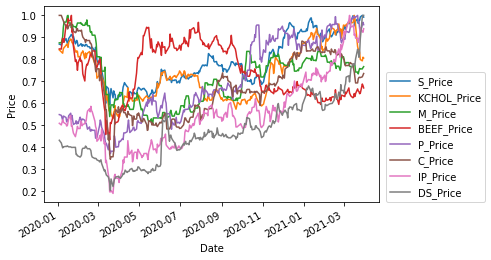

In [18]:
# Plot daily prices

plot_prices(df = stock_prices_daily_normalized)

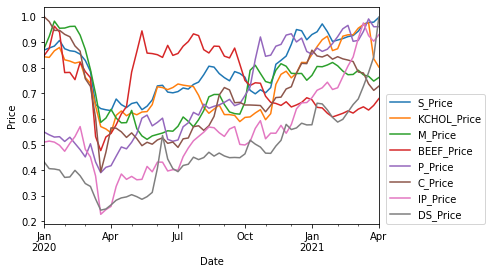

In [19]:
# Plot weekly prices

plot_prices(df = stock_prices_weekly_normalized)

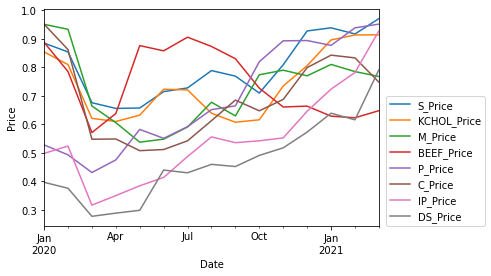

In [20]:
# Plot monthly prices

plot_prices(df = stock_prices_monthly_normalized)

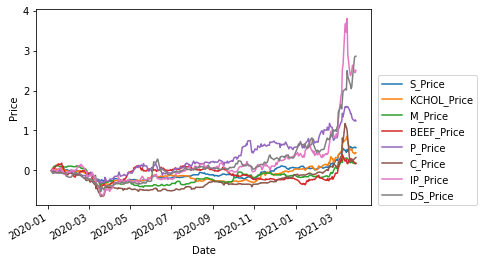

In [21]:
# Plot multiperiod return

plot_prices(df = stock_returns_daily_pr)


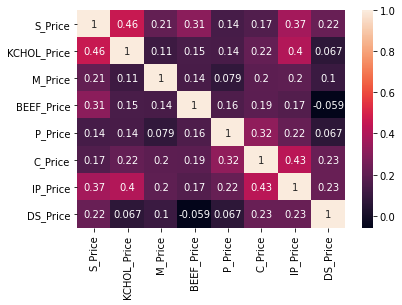

In [22]:
# Plot a correlation heatmap among all the stocks

corr_matrix = stock_returns_daily.corr()

# Plot the heatmap

sns.heatmap(corr_matrix, annot = True)
plt.show()

## Feature Engineering

In [23]:
# Define a function to use MaxMin Scaler for the modeling part

def scaler(train_array, test_array):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    return X, y

In [24]:
# Define a function to calculate the real price of the stock based on the MinMax Scaler

def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    y_inverse = scaler.inverse_transform(predictions)
    return y_inverse

In [25]:
# Define a function to have the previous 5 days as independant features to predict the stock price

def preprocessing(dataset, time_steps = 1):
    X, y = [], []
    for i in range(len(dataset) - time_steps - 1):
        x = dataset[i:(i + time_steps), 0]
        X.append(x)
        y.append(dataset[i + time_steps, 0])
    return X, y

In [26]:
# Divide the train and test data

train = stock_prices_daily['2020']
test = stock_prices_daily['2021']

In [27]:
# Define an empty array to change the shape of the X variable (train and test)
# The new shape with treat the stock prices as each of the subarrays
# Eight stocks mean an array with shape (8, n_days)

n_days = len(stock_prices_daily)

# Define number of stocks

n_stocks = len(stock_prices_daily.columns)

# Save the number of days that are going to be used as train and test

n_days_train = len(train)
n_days_test = len(test)

# Empty array for the train and test data

train_scale = np.zeros(shape = (n_stocks, n_days_train))

test_scale = np.zeros(shape = (n_stocks, n_days_test))

# Use the for loop to iterate over the train and test to have the array shape changed

for i in range(0, n_stocks):
    train_scale[i] = train.iloc[:,i]
    
for i in range(0, n_stocks):
    test_scale[i] = test.iloc[:,i]


### Apply the Scaler function to the stocks

In [28]:
# Empty arrays for the train and test data (n_stocks, ndays, 1) to make it usable after using the MinMax Scaler

Xtrain = np.empty(shape = (n_stocks, n_days_train, 1))

Xtest = np.empty(shape = (n_stocks, n_days_test, 1))

# For loop to create the Xtrain and Xtest and scale the data (by just fitting the train data). 
# The idea is to avoid the data leakage by scaling the complete data set

for i in range(n_stocks):
    Xtrain[i], Xtest[i] = scaler(train_array = train_scale[i], test_array = test_scale[i])
    

In [29]:
# Get together the Xtrain and Xtest to apply some feature engineering (Make previous 5 days as independent variables)
# and the day ahead the dependant variable

# Define the empty array to iterate over an array (more time efficient)

Values = np.empty(shape = (n_stocks, n_days, 1))

#Iterate by concatenating the Xtrain and Xtest

for i in range(n_stocks):
    Values[i] = np.concatenate((Xtrain[i], Xtest[i]))

In [30]:
# Use the function to use the previous 5 days as independent features for train data

time_steps = 5

# Make two empty list to store the data

X = []
y = []

for i in range(0, n_stocks):
    # Use the preprocessing function 
    a,b = preprocessing(dataset = Values[i], time_steps = time_steps)
    # Apend the values
    X.append(a)
    y.append(b)

# Make sure to have them as arrays

X = np.array(X)
y = np.array(y)

In [31]:
# X_train array will have new shape

# Define the new days for each subarray

n_days_train_resample = n_days_train - time_steps - 1

# Make empty arrays with the reshape of the data after taking the 5 days as independant variables

X_train = np.empty(shape = (n_stocks, n_days_train_resample, 5))

y_train = np.empty(shape = (n_stocks, n_days_train_resample))

X_test = np.empty(shape = (n_stocks, n_days_test, 5))

y_test = np.empty(shape = (n_stocks, n_days_test))

In [32]:
# Start for the X_train, y_train, X_test, y_test

for i in range(n_stocks):
    X_train[i], y_train[i] = X[i][:n_days_train_resample], y[i][:n_days_train_resample]
    X_test[i], y_test[i] = X[i][n_days_train_resample:], y[i][n_days_train_resample:]

In [33]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , X_test.shape[2], 1)

In [34]:
print('Shape of the train data to use at the model', X_train.shape, y_train.shape)
print('Shape of the test data to use', X_test.shape, y_test.shape)

Shape of the train data to use at the model (8, 244, 5, 1) (8, 244)
Shape of the test data to use (8, 61, 5, 1) (8, 61)


## Modeling

### LSTM

In [35]:
# Define a model to build the neural network

def neural_network():
    # Begin with Sequential
    regressor = Sequential()
    # The first layer would the be LSTM
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (5,1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [36]:
# Define a variable to reshape the train and test data into shape (, , 1) to make it processable on the neural network

def variables_model(n):
    x_train, Y_train = X_train[n], y_train[n]
    x_test, Y_test = X_test[n], y_test[n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    return (x_train, x_test, Y_train, Y_test)
    

In [37]:
# Fit the model and get the predictions

def model_fit(Xtr, ytr, Xte):
    model.fit(Xtr, ytr, epochs = 100, batch_size = 32)
    pred = model.predict(Xte)
    return pred

In [38]:
# For future use in plotting, create one data frame to have the train values plus the test values
# and another pandas series to have the train data plus the predicted values

def df_merger(train_data, test_data, pred_values):
    actual_data = train_data.append(test_data)
    predicted_data = train_data.append(pred_values)
    return actual_data, predicted_data

In [39]:
# Compare actual values with predicted values with a plot

def plot_comparison(actual, predicted, string):
    #Visualizing the prediction
    plt.figure(figsize=(10,6))
    plt.plot(actual[:'2020-12-30'], color = 'blue')
    plt.plot(actual['2020-12-30':], color = 'orange', label = 'Actual Values')
    plt.plot(predicted['2020-12-30':], color = 'green', label = 'Predicted Values')
    plt.title(string)
    plt.xlabel('Trading Day')
    plt.ylabel('Price')
    plt.legend()
    return plt.show()
    

In [40]:
# Save a data frame to concat all the predictions

# Start with an empty data frame
predictions_df = pd.DataFrame()

# Start with the same date than the test for the comparisons.
predictions_df['Date'] = test.index

#Set the date as the index
predictions_df.set_index('Date', inplace = True)

In [41]:
# Define the model

model = neural_network()

In [42]:
# Check the summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

#### S_Stock

In [43]:
# Get the data for this stock

S_Xtrain, S_Xtest, S_ytrain, S_ytest = variables_model(n = 0)

In [44]:
# Fit the data for the stock

S_pred = model_fit(Xtr = S_Xtrain, ytr = S_ytrain, Xte = S_Xtest)


Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 281us/sample - loss: 0.2052
Epoch 2/100
244/244 [==============================] - 0s 331us/sample - loss: 0.0798
Epoch 3/100
244/244 [==============================] - 0s 265us/sample - loss: 0.0332
Epoch 4/100
244/244 [==============================] - 0s 292us/sample - loss: 0.0233
Epoch 5/100
244/244 [==============================] - 0s 254us/sample - loss: 0.0210
Epoch 6/100
244/244 [==============================] - 0s 311us/sample - loss: 0.0146
Epoch 7/100
244/244 [==============================] - 0s 278us/sample - loss: 0.0131
Epoch 8/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0106
Epoch 9/100
244/244 [==============================] - 0s 315us/sample - loss: 0.0088
Epoch 10/100
244/244 [==============================] - 0s 269us/sample - loss: 0.0091
Epoch 11/100
244/244 [==============================] - 0s 251us/sample - loss: 0.0108
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 287us/sample - loss: 0.0059
Epoch 96/100
244/244 [==============================] - 0s 299us/sample - loss: 0.0064
Epoch 97/100
244/244 [==============================] - 0s 264us/sample - loss: 0.0057
Epoch 98/100
244/244 [==============================] - 0s 266us/sample - loss: 0.0075
Epoch 99/100
244/244 [==============================] - 0s 277us/sample - loss: 0.0062
Epoch 100/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0064
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [45]:
# Use the inverse transform function

S_pred_prices = scaler_inverse(train_array = train['S_Price'].values, predictions = S_pred)


In [46]:
# Add the first column to the data frame that will store the predictions

predictions_df['S_Price'] = S_pred_prices


In [47]:
# Get the actual and predicted data as data frames for both

S_actual, S_predicted = df_merger(train_data = train['S_Price'], test_data = test['S_Price'], 
                                  pred_values = predictions_df['S_Price'])


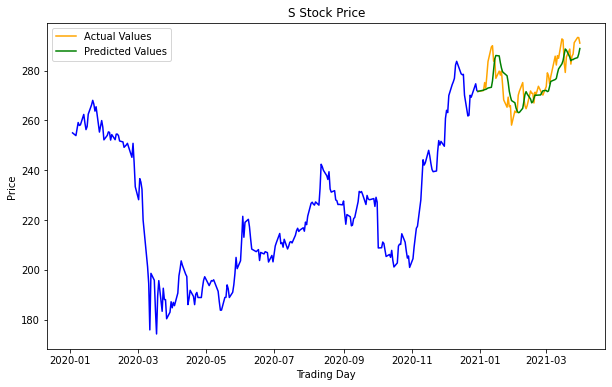

In [48]:
# Plot the S Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predicted, string = 'S Stock Price')

#### KCHOL Stock

In [49]:
# Get the data for this stock

KCHOL_Xtrain, KCHOL_Xtest, KCHOL_ytrain, KCHOL_ytest = variables_model(n = 1)

In [50]:
# Fit the model

KCHOL_pred = model_fit(Xtr = KCHOL_Xtrain, ytr = KCHOL_ytrain, Xte = KCHOL_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 231us/sample - loss: 0.0063
Epoch 2/100
244/244 [==============================] - 0s 229us/sample - loss: 0.0070
Epoch 3/100
244/244 [==============================] - 0s 227us/sample - loss: 0.0065
Epoch 4/100
244/244 [==============================] - 0s 230us/sample - loss: 0.0058
Epoch 5/100
244/244 [==============================] - 0s 301us/sample - loss: 0.0060
Epoch 6/100
244/244 [==============================] - 0s 249us/sample - loss: 0.0073
Epoch 7/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0068
Epoch 8/100
244/244 [==============================] - 0s 336us/sample - loss: 0.0077
Epoch 9/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0066
Epoch 10/100
244/244 [==============================] - 0s 304us/sample - loss: 0.0069
Epoch 11/100
244/244 [==============================] - 0s 311us/sample - loss: 0.0071
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 284us/sample - loss: 0.0042
Epoch 96/100
244/244 [==============================] - 0s 292us/sample - loss: 0.0044
Epoch 97/100
244/244 [==============================] - 0s 292us/sample - loss: 0.0042
Epoch 98/100
244/244 [==============================] - 0s 295us/sample - loss: 0.0042
Epoch 99/100
244/244 [==============================] - 0s 287us/sample - loss: 0.0042
Epoch 100/100
244/244 [==============================] - 0s 286us/sample - loss: 0.0042


In [51]:
# Save the actual and predicted values in different data frames to plot

KCHOL_pred_prices = scaler_inverse(train_array = train['KCHOL_Price'].values, predictions = KCHOL_pred)

In [52]:
# Add the first column to the data frame that will store the predictions

predictions_df['KCHOL_Price'] = KCHOL_pred_prices

In [53]:
# Get the actual and predicted data as data frames for both

KCHOL_actual, KCHOL_predicted = df_merger(train_data = train['KCHOL_Price'], test_data = test['KCHOL_Price'], 
                                  pred_values = predictions_df['KCHOL_Price'])

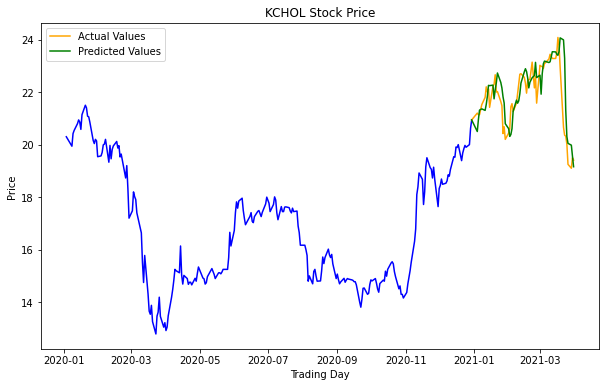

In [54]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predicted, string = 'KCHOL Stock Price')

#### M Stock

In [55]:
# Get the data for this stock

M_Xtrain, M_Xtest, M_ytrain, M_ytest = variables_model(n = 2)

In [56]:
# Fit the model

M_pred = model_fit(Xtr = M_Xtrain, ytr = M_ytrain, Xte = M_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 254us/sample - loss: 0.0028
Epoch 2/100
244/244 [==============================] - 0s 266us/sample - loss: 0.0026
Epoch 3/100
244/244 [==============================] - 0s 280us/sample - loss: 0.0029
Epoch 4/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0026
Epoch 5/100
244/244 [==============================] - 0s 273us/sample - loss: 0.0029
Epoch 6/100
244/244 [==============================] - 0s 301us/sample - loss: 0.0027
Epoch 7/100
244/244 [==============================] - 0s 295us/sample - loss: 0.0028
Epoch 8/100
244/244 [==============================] - 0s 277us/sample - loss: 0.0029
Epoch 9/100
244/244 [==============================] - 0s 274us/sample - loss: 0.0031
Epoch 10/100
244/244 [==============================] - 0s 310us/sample - loss: 0.0029
Epoch 11/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0026
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 330us/sample - loss: 0.0027
Epoch 96/100
244/244 [==============================] - 0s 299us/sample - loss: 0.0022
Epoch 97/100
244/244 [==============================] - 0s 322us/sample - loss: 0.0031
Epoch 98/100
244/244 [==============================] - 0s 281us/sample - loss: 0.0028
Epoch 99/100
244/244 [==============================] - 0s 292us/sample - loss: 0.0027
Epoch 100/100
244/244 [==============================] - 0s 302us/sample - loss: 0.0025


In [57]:
# Save the actual and predicted values in different data frames to plot

M_pred_prices = scaler_inverse(train_array = train['M_Price'].values, predictions = M_pred)

In [58]:
# Add the first column to the data frame that will store the predictions

predictions_df['M_Price'] = M_pred_prices

In [59]:
# Get the actual and predicted data as data frames for both

M_actual, M_predicted = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = predictions_df['M_Price'])

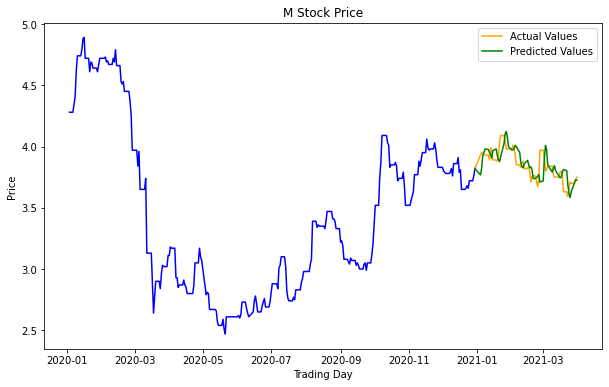

In [60]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predicted, string = 'M Stock Price')

#### BEEF Stock

In [61]:
# Get the data for this stock

BEEF_Xtrain, BEEF_Xtest, BEEF_ytrain, BEEF_ytest = variables_model(n = 3)

In [62]:
# Fit the model

BEEF_pred = model_fit(Xtr = BEEF_Xtrain, ytr = BEEF_ytrain, Xte = BEEF_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 265us/sample - loss: 0.0038
Epoch 2/100
244/244 [==============================] - 0s 277us/sample - loss: 0.0041
Epoch 3/100
244/244 [==============================] - 0s 294us/sample - loss: 0.0045
Epoch 4/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0044
Epoch 5/100
244/244 [==============================] - 0s 296us/sample - loss: 0.0040
Epoch 6/100
244/244 [==============================] - 0s 269us/sample - loss: 0.0039
Epoch 7/100
244/244 [==============================] - 0s 273us/sample - loss: 0.0041
Epoch 8/100
244/244 [==============================] - 0s 321us/sample - loss: 0.0043
Epoch 9/100
244/244 [==============================] - 0s 261us/sample - loss: 0.0038
Epoch 10/100
244/244 [==============================] - 0s 281us/sample - loss: 0.0037
Epoch 11/100
244/244 [==============================] - 0s 273us/sample - loss: 0.0036
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 278us/sample - loss: 0.0027
Epoch 96/100
244/244 [==============================] - 0s 286us/sample - loss: 0.0036
Epoch 97/100
244/244 [==============================] - 0s 289us/sample - loss: 0.0032
Epoch 98/100
244/244 [==============================] - 0s 278us/sample - loss: 0.0032
Epoch 99/100
244/244 [==============================] - 0s 290us/sample - loss: 0.0034
Epoch 100/100
244/244 [==============================] - 0s 289us/sample - loss: 0.0039


In [63]:
# Save the actual and predicted values in different data frames to plot

BEEF_pred_prices = scaler_inverse(train_array = train['BEEF_Price'].values, predictions = BEEF_pred)

In [64]:
# Add the first column to the data frame that will store the predictions

predictions_df['BEEF_Price'] = BEEF_pred_prices

In [65]:
# Get the actual and predicted data as data frames for both

BEEF_actual, BEEF_predicted = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = predictions_df['BEEF_Price'])

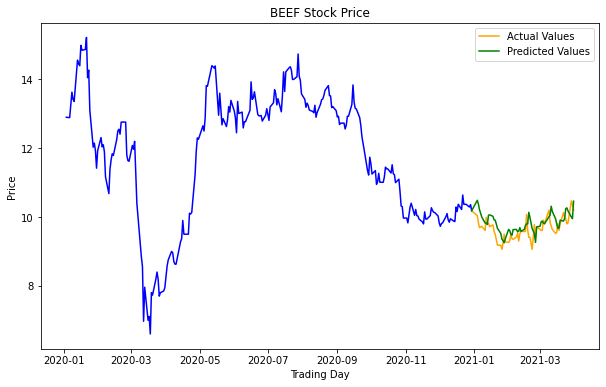

In [66]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predicted, string = 'BEEF Stock Price')

#### P Stock

In [67]:
# Get the data for this stock

P_Xtrain, P_Xtest, P_ytrain, P_ytest = variables_model(n = 4)

In [68]:
# Fit the model

P_pred = model_fit(Xtr = P_Xtrain, ytr = P_ytrain, Xte = P_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0030
Epoch 2/100
244/244 [==============================] - 0s 230us/sample - loss: 0.0033
Epoch 3/100
244/244 [==============================] - 0s 229us/sample - loss: 0.0028
Epoch 4/100
244/244 [==============================] - 0s 336us/sample - loss: 0.0024
Epoch 5/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0024
Epoch 6/100
244/244 [==============================] - 0s 278us/sample - loss: 0.0028
Epoch 7/100
244/244 [==============================] - 0s 318us/sample - loss: 0.0026
Epoch 8/100
244/244 [==============================] - 0s 327us/sample - loss: 0.0031
Epoch 9/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0025
Epoch 10/100
244/244 [==============================] - 0s 306us/sample - loss: 0.0021
Epoch 11/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0030
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 319us/sample - loss: 0.0024
Epoch 96/100
244/244 [==============================] - 0s 387us/sample - loss: 0.0025
Epoch 97/100
244/244 [==============================] - 0s 352us/sample - loss: 0.0024
Epoch 98/100
244/244 [==============================] - 0s 384us/sample - loss: 0.0025
Epoch 99/100
244/244 [==============================] - 0s 349us/sample - loss: 0.0024
Epoch 100/100
244/244 [==============================] - 0s 355us/sample - loss: 0.0025


In [69]:
# Save the actual and predicted values in different data frames to plot

P_pred_prices = scaler_inverse(train_array = train['P_Price'].values, predictions = P_pred)

In [70]:
# Add the first column to the data frame that will store the predictions

predictions_df['P_Price'] = P_pred_prices

In [71]:
# Get the actual and predicted data as data frames for both

P_actual, P_predicted = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = predictions_df['P_Price'])

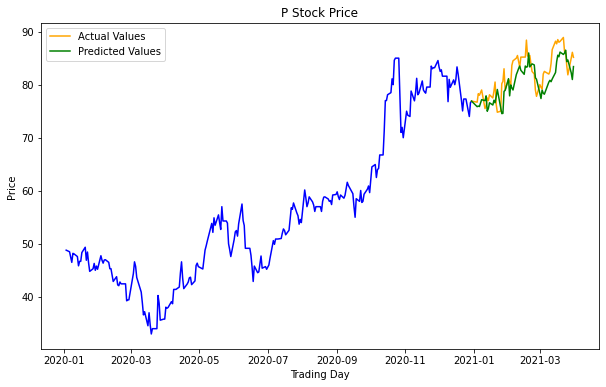

In [72]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predicted, string = 'P Stock Price')

#### C Stock

In [73]:
# Get the data for this stock

C_Xtrain, C_Xtest, C_ytrain, C_ytest = variables_model(n = 5)

In [74]:
# Fit the model

C_pred = model_fit(Xtr = C_Xtrain, ytr = C_ytrain, Xte = C_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 251us/sample - loss: 0.0016
Epoch 2/100
244/244 [==============================] - 0s 295us/sample - loss: 0.0017
Epoch 3/100
244/244 [==============================] - 0s 269us/sample - loss: 0.0018
Epoch 4/100
244/244 [==============================] - 0s 250us/sample - loss: 0.0017
Epoch 5/100
244/244 [==============================] - 0s 310us/sample - loss: 0.0017
Epoch 6/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0019
Epoch 7/100
244/244 [==============================] - 0s 318us/sample - loss: 0.0018
Epoch 8/100
244/244 [==============================] - 0s 272us/sample - loss: 0.0017
Epoch 9/100
244/244 [==============================] - 0s 264us/sample - loss: 0.0017
Epoch 10/100
244/244 [==============================] - 0s 300us/sample - loss: 0.0018
Epoch 11/100
244/244 [==============================] - 0s 254us/sample - loss: 0.0017
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 301us/sample - loss: 0.0015
Epoch 96/100
244/244 [==============================] - 0s 294us/sample - loss: 0.0016
Epoch 97/100
244/244 [==============================] - 0s 293us/sample - loss: 0.0015
Epoch 98/100
244/244 [==============================] - 0s 289us/sample - loss: 0.0014
Epoch 99/100
244/244 [==============================] - 0s 291us/sample - loss: 0.0015
Epoch 100/100
244/244 [==============================] - 0s 305us/sample - loss: 0.0017


In [75]:
# Save the actual and predicted values in different data frames to plot

C_pred_prices = scaler_inverse(train_array = train['C_Price'].values, predictions = C_pred)

In [76]:
# Add the first column to the data frame that will store the predictions

predictions_df['C_Price'] = C_pred_prices

In [77]:
# Get the actual and predicted data as data frames for both

C_actual, C_predicted = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = predictions_df['C_Price'])

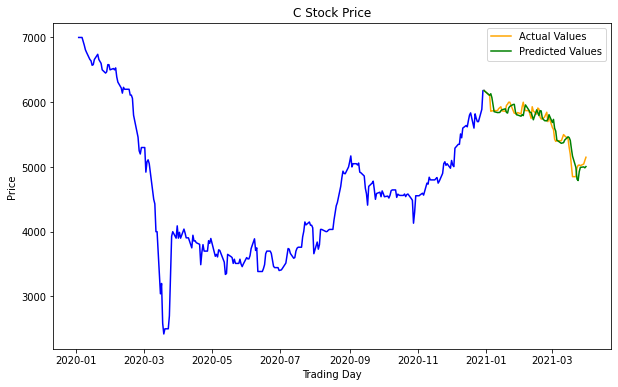

In [78]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predicted, string = 'C Stock Price')

#### IP Stock

In [79]:
# Get the data for this stock

IP_Xtrain, IP_Xtest, IP_ytrain, IP_ytest = variables_model(n = 6)

In [80]:
# Fit the model

IP_pred = model_fit(Xtr = IP_Xtrain, ytr = IP_ytrain, Xte = IP_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0029
Epoch 2/100
244/244 [==============================] - 0s 285us/sample - loss: 0.0026
Epoch 3/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0029
Epoch 4/100
244/244 [==============================] - 0s 292us/sample - loss: 0.0027
Epoch 5/100
244/244 [==============================] - 0s 263us/sample - loss: 0.0030
Epoch 6/100
244/244 [==============================] - 0s 283us/sample - loss: 0.0025
Epoch 7/100
244/244 [==============================] - 0s 249us/sample - loss: 0.0028
Epoch 8/100
244/244 [==============================] - 0s 310us/sample - loss: 0.0026
Epoch 9/100
244/244 [==============================] - 0s 278us/sample - loss: 0.0026
Epoch 10/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0028
Epoch 11/100
244/244 [==============================] - 0s 303us/sample - loss: 0.0032
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 288us/sample - loss: 0.0028
Epoch 96/100
244/244 [==============================] - 0s 282us/sample - loss: 0.0027
Epoch 97/100
244/244 [==============================] - 0s 305us/sample - loss: 0.0027
Epoch 98/100
244/244 [==============================] - 0s 316us/sample - loss: 0.0027
Epoch 99/100
244/244 [==============================] - 0s 284us/sample - loss: 0.0026
Epoch 100/100
244/244 [==============================] - 0s 300us/sample - loss: 0.0029


In [81]:
# Save the actual and predicted values in different data frames to plot

IP_pred_prices = scaler_inverse(train_array = train['IP_Price'].values, predictions = IP_pred)

In [82]:
# Add the first column to the data frame that will store the predictions

predictions_df['IP_Price'] = IP_pred_prices

In [83]:
# Get the actual and predicted data as data frames for both

IP_actual, IP_predicted = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = predictions_df['IP_Price'])

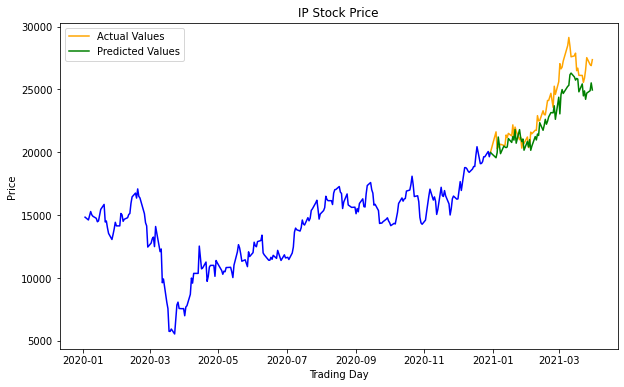

In [84]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predicted, string = 'IP Stock Price')

#### DS Stock

In [85]:
# Get the data for this stock

DS_Xtrain, DS_Xtest, DS_ytrain, DS_ytest = variables_model(n = 7)

In [86]:
# Fit the model

DS_pred = model_fit(Xtr = DS_Xtrain, ytr = DS_ytrain, Xte = DS_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 250us/sample - loss: 0.0028
Epoch 2/100
244/244 [==============================] - 0s 293us/sample - loss: 0.0028
Epoch 3/100
244/244 [==============================] - 0s 257us/sample - loss: 0.0027
Epoch 4/100
244/244 [==============================] - 0s 268us/sample - loss: 0.0027
Epoch 5/100
244/244 [==============================] - 0s 307us/sample - loss: 0.0024
Epoch 6/100
244/244 [==============================] - 0s 298us/sample - loss: 0.0028
Epoch 7/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0026
Epoch 8/100
244/244 [==============================] - 0s 309us/sample - loss: 0.0027
Epoch 9/100
244/244 [==============================] - 0s 250us/sample - loss: 0.0027
Epoch 10/100
244/244 [==============================] - 0s 278us/sample - loss: 0.0024
Epoch 11/100
244/244 [==============================] - 0s 296us/sample - loss: 0.0029
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 282us/sample - loss: 0.0029
Epoch 96/100
244/244 [==============================] - 0s 298us/sample - loss: 0.0029
Epoch 97/100
244/244 [==============================] - 0s 273us/sample - loss: 0.0026
Epoch 98/100
244/244 [==============================] - 0s 297us/sample - loss: 0.0021
Epoch 99/100
244/244 [==============================] - 0s 281us/sample - loss: 0.0026
Epoch 100/100
244/244 [==============================] - 0s 269us/sample - loss: 0.0025


In [87]:
# Save the actual and predicted values in different data frames to plot

DS_pred_prices = scaler_inverse(train_array = train['DS_Price'].values, predictions = DS_pred)

In [88]:
# Add the first column to the data frame that will store the predictions

predictions_df['DS_Price'] = DS_pred_prices

In [89]:
# Get the actual and predicted data as data frames for both

DS_actual, DS_predicted = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = predictions_df['DS_Price'])

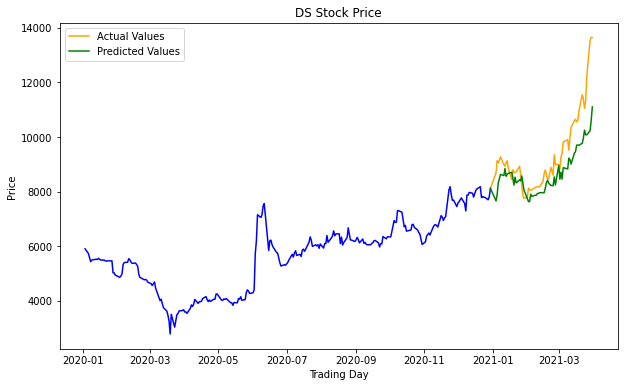

In [90]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predicted, string = 'DS Stock Price')

### SARIMAX

In [91]:
def arima_selection(values):
    model_autoARIMA = auto_arima(y = values, x = None, start_p = 1, d = None, start_q = 1, max_p = 11, max_d = 11,
                                max_q = 11, start_P = 1, D = None, start_Q = 1, max_P = 11, max_D = 11, max_Q = 11,
                                max_order = None, m = 5, alpha = 0.05, n_jobs = -1)
    return model_autoARIMA, model_autoARIMA.summary()


In [92]:
def model_fit(col, order):
    
    warnings.filterwarnings('ignore')

    train_values = train[col].values

    test_values = test[col].values
    
    predictions = np.empty(shape = len(test))
    
    for i in range(len(test)):
        model = ARIMA(endog = train_values, order = order)
        model = model.fit()
        output = model.forecast()
        p = output[0]
        predictions[i] = p
        obs = test_values[i]
        train_values = np.append(train_values, obs)
        
    return predictions
        

In [93]:
pred_arima = pd.DataFrame()

pred_arima['Date'] = test.index

pred_arima.set_index('Date', inplace = True)

#### S Stock

In [94]:
# Get the best order to train the ARIMA model

arima_selection(values = train['S_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -747.842
 Date:                Mon, 07 Jun 2021   AIC                           1497.685
 Time:                        20:35:14   BIC                           1501.202
 Sample:                             0   HQIC                          1499.101
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2        23.7810    

In [95]:
# Use the function to predict the outcomes

S_pred_arima = model_fit(col = 'S_Price', order = (0,1,0))

In [96]:
# Save the predicted prices in a new column

pred_arima['S_Price'] = S_pred_arima

In [97]:
# Get the actual and predicted data as data frames for both

S_actual_arima, S_predicted_arima = df_merger(train_data = train['S_Price'], 
                                                      test_data = test['S_Price'], 
                                                      pred_values = pred_arima['S_Price'])

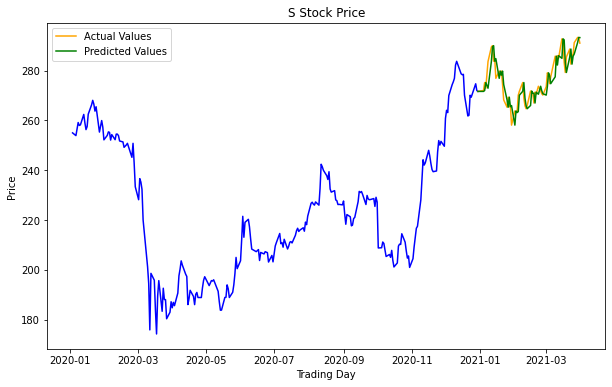

In [98]:
# Plot the Stock Price comparison

plot_comparison(actual = S_actual_arima, predicted = S_predicted_arima, string = 'S Stock Price')

#### KCHOL Stock

In [99]:
# Get the best order to train the ARIMA model

arima_selection(values = train['KCHOL_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -126.205
 Date:                Mon, 07 Jun 2021   AIC                            254.410
 Time:                        20:35:17   BIC                            257.927
 Sample:                             0   HQIC                           255.826
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.1613    

In [100]:
# Use the function to predict the outcomes

KCHOL_pred_arima = model_fit(col = 'KCHOL_Price', order = (0,1,0))

In [101]:
# Save the predicted prices in a new column

pred_arima['KCHOL_Price'] = KCHOL_pred_arima

In [102]:
# Get the actual and predicted data as data frames for both

KCHOL_actual_arima, KCHOL_predicted_arima = df_merger(train_data = train['KCHOL_Price'], 
                                                      test_data = test['KCHOL_Price'], 
                                                      pred_values = pred_arima['KCHOL_Price'])

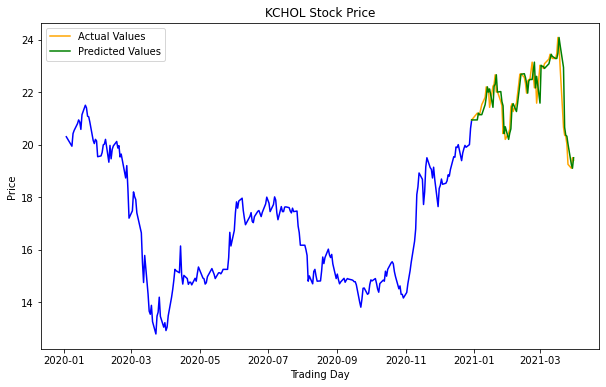

In [103]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual_arima, predicted = KCHOL_predicted_arima, string = 'KCHOL Stock Price')

#### M Stock

In [104]:
# Get the best order to train the ARIMA model

arima_selection(values = train['M_Price'])

(ARIMA(order=(0, 1, 4), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 4)   Log Likelihood                 252.477
 Date:                Mon, 07 Jun 2021   AIC                           -494.954
 Time:                        20:35:29   BIC                           -477.366
 Sample:                             0   HQIC                          -487.875
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ma.L1          0.0498    

In [105]:
# Use the function to predict the outcomes

M_pred_arima = model_fit(col = 'M_Price', order = (0,1,4))

In [106]:
pred_arima['M_Price'] = M_pred_arima

In [107]:
# Get the actual and predicted data as data frames for both

M_actual_arima, M_predicted_arima = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = pred_arima['M_Price'])

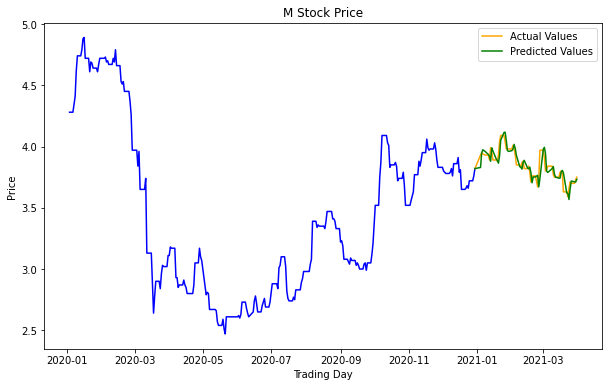

In [108]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual_arima, predicted = M_predicted_arima, string = 'M Stock Price')

#### BEEF Stock

In [109]:
# Get the best order to train the ARIMA model

arima_selection(values = train['BEEF_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -127.797
 Date:                Mon, 07 Jun 2021   AIC                            257.595
 Time:                        20:35:37   BIC                            261.112
 Sample:                             0   HQIC                           259.011
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.1634    

In [110]:
# Use the function to predict the outcomes

BEEF_pred_arima = model_fit(col = 'BEEF_Price', order = (0,1,0))

In [111]:
# Save prices in a column of the data frame

pred_arima['BEEF_Price'] = BEEF_pred_arima

In [112]:
# Get the actual and predicted data as data frames for both

BEEF_actual_arima, BEEF_predicted_arima = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = pred_arima['BEEF_Price'])

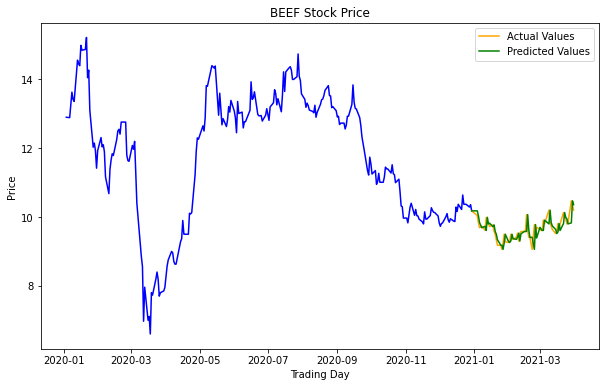

In [113]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual_arima, predicted = BEEF_predicted_arima, string = 'BEEF Stock Price')

#### P Stock

In [114]:
# Get the best order to train the ARIMA model

arima_selection(values = train['P_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -522.848
 Date:                Mon, 07 Jun 2021   AIC                           1047.695
 Time:                        20:35:39   BIC                           1051.213
 Sample:                             0   HQIC                          1049.111
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         3.9028    

In [115]:
# Use the function to predict the outcomes

P_pred_arima = model_fit(col = 'P_Price', order = (0,1,0))

In [116]:
pred_arima['P_Price'] = P_pred_arima

In [117]:
# Get the actual and predicted data as data frames for both

P_actual_arima, P_predicted_arima = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = pred_arima['P_Price'])

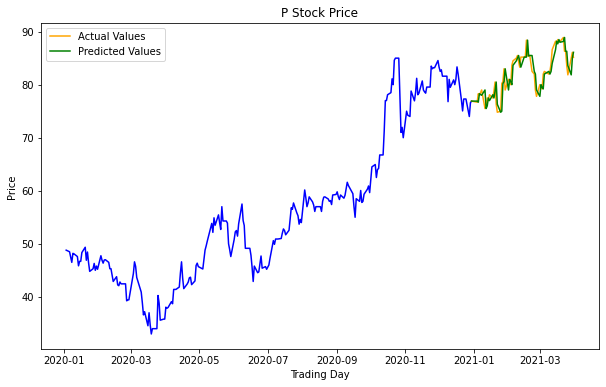

In [118]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual_arima, predicted = P_predicted_arima, string = 'P Stock Price')

#### C Stock

In [119]:
# Get the best order to train the ARIMA model

arima_selection(values = train['C_Price'])

(ARIMA(order=(2, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1593.351
 Date:                Mon, 07 Jun 2021   AIC                           3194.701
 Time:                        20:35:47   BIC                           3208.755
 Sample:                             0   HQIC                          3200.359
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          0.0525    

In [120]:
# Use the function to predict the outcomes

C_pred_arima = model_fit(col = 'C_Price', order = (2,2,1))


In [121]:
# Save results in the predicted data frame

pred_arima['C_Price'] = C_pred_arima

In [122]:
# Get the actual and predicted data as data frames for both

C_actual_arima, C_predicted_arima = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = pred_arima['C_Price'])

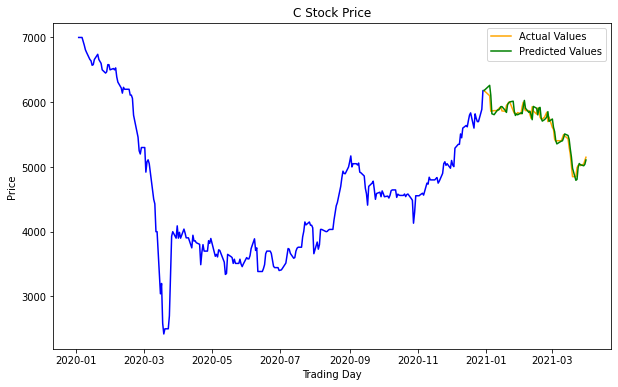

In [123]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual_arima, predicted = C_predicted_arima, string = 'C Stock Price')

#### IP Stock

In [124]:
# Get the best order to train the ARIMA model

arima_selection(values = train['IP_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 1, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                      
 Dep. Variable:                                   y   No. Observations:                  250
 Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -1964.063
 Date:                             Mon, 07 Jun 2021   AIC                           3932.126
 Time:                                     20:36:00   BIC                           3939.161
 Sample:                                          0   HQIC                          3934.957
                                              - 250                                         
 Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 -

In [125]:
# Use the function to predict the outcomes

IP_pred_arima = model_fit(col = 'IP_Price', order = (0,1,0))


In [126]:
pred_arima['IP_Price'] = IP_pred_arima

In [127]:
# Get the actual and predicted data as data frames for both

IP_actual_arima, IP_predicted_arima = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = pred_arima['IP_Price'])

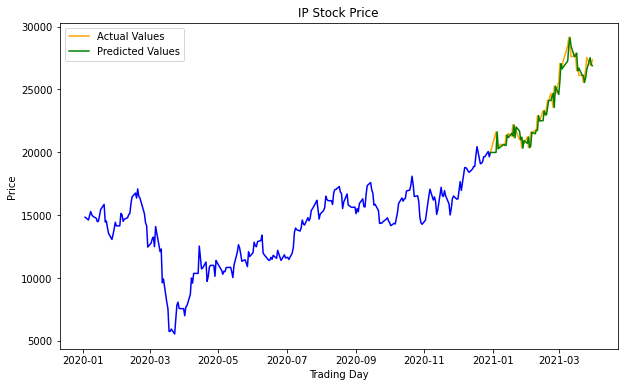

In [128]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual_arima, predicted = IP_predicted_arima, string = 'IP Stock Price')

#### DS Stock

In [129]:
# Get the best order to train the ARIMA model

arima_selection(values = train['DS_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1711.671
 Date:                Mon, 07 Jun 2021   AIC                           3425.341
 Time:                        20:36:02   BIC                           3428.859
 Sample:                             0   HQIC                          3426.757
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2      5.475e+04   1

In [130]:
# Use the function to predict the outcomes

DS_pred_arima = model_fit(col = 'DS_Price', order = (0,1,0))


In [131]:
pred_arima['DS_Price'] = DS_pred_arima

In [132]:
# Get the actual and predicted data as data frames for both

DS_actual_arima, DS_predicted_arima = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = pred_arima['DS_Price'])

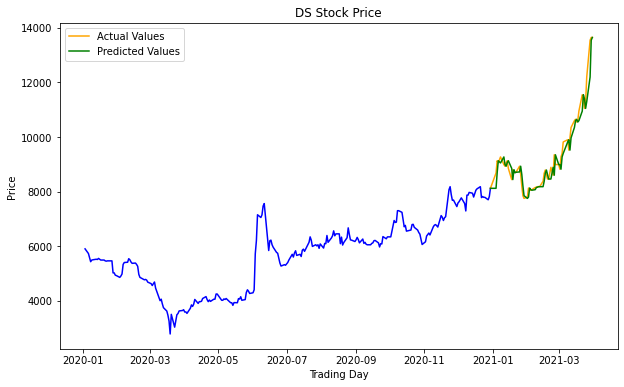

In [133]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual_arima, predicted = DS_predicted_arima, string = 'DS Stock Price')

## Model Evaluation

In [134]:
def capital_gain_predicted_prices(df1, df2):
    # Define the total capital gain as the final value minus the initial value divided by the initial value
    actual_returns = (df1[-1] - df1[0])/df1[0]
    # Predicted returns 
    predicted_returns = (df2[-1] - df2[0])/df2[0]
    # Show the value as percentage
    actual_returns = round(actual_returns*100,2)
    predicted_returns = round(predicted_returns*100, 2)
    print('The actual returns had a value of {}% and the predicted returns had a value {}%'.format(actual_returns, 
                                                                                                predicted_returns))

In [135]:
# Define a function for the Bollinger brands

def bollinger_bands(df, col, p, std):
    # Create a new data frame just to use in the function to plot the upper, and lower bound with the moving average
    # and the closing price
    bollinger_df = pd.DataFrame()
    #Establish the serie to use the rolling function
    bollinger_df[col] = df[col].astype(int)
    # Define number of periods
    period = p
    # Apply the rolling function for the moving average
    bollinger_df['SMA'] = bollinger_df.rolling(window = period).mean()
    # Calculate the Standard Deviation
    bollinger_df['std'] = bollinger_df[col].rolling(window = period).std()
    # Establish the upper border
    bollinger_df['upper'] = bollinger_df['SMA'] + (bollinger_df['std'] * std)
    # Establish the lower border
    bollinger_df['lower'] = bollinger_df['SMA'] - (bollinger_df['std'] * std)
    
    # Define the conditions to make the buy/sell recommendations
    buy_signal = []
    sell_signal = []
    
    # Start a for loop
    for i in range(len(bollinger_df[col])):
        if bollinger_df[col][i] > bollinger_df['upper'][i]: # This is the condition for sell recommendation 
            buy_signal.append(np.nan)
            sell_signal.append(bollinger_df[col][i])
        elif bollinger_df[col][i] < bollinger_df['lower'][i]: # This is the condition for buy recommendation
            buy_signal.append(bollinger_df[col][i])
            sell_signal.append(np.nan)
        else: # If none of the conditions are met, then no recommendation is given
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    # Add the recommendations as a columns in the data frame
    bollinger_df['buy'] = buy_signal
    bollinger_df['sell'] = sell_signal
    
    # Plot the bollinger bands in order to make the sell and buy recommendations
    fig = plt.figure(figsize = (20,12))
    # Add subplot
    ax = fig.add_subplot(1,1,1)
    # Get the index
    x_axis = bollinger_df.index
    # Plot the shade area between the upper and the lower bound
    ax.fill_between(x_axis, bollinger_df['upper'], bollinger_df['lower'], color = 'grey')
    # Plot the closing price, moving average and buy and sell recommendations
    ax.plot(x_axis, bollinger_df[col], color = 'gold', lw = 3, label = 'Price')
    ax.plot(x_axis, bollinger_df['SMA'], color = 'blue', lw = 3, label = 'Moving Averag')
    ax.scatter(x_axis, bollinger_df['buy'], color = 'green', lw = 3, marker = '^', label = 'Buy', s = 100)
    ax.scatter(x_axis, bollinger_df['sell'], color = 'red', lw = 3, marker = 'v', label = 'Sell', s = 100)
    # Set the axis
    ax.set_title('Bollinger bands for {}'.format(col))
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.xticks(rotation = 45)
    ax.legend(loc = (1.02, 0.6))
    return plt.show()


In [136]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df = merge_df(df1 = S_predicted, df2 = KCHOL_predicted, df3 = M_predicted, df4 = BEEF_predicted, 
                        df5 = P_predicted, df6 = C_predicted, df7 = IP_predicted, df8 = DS_predicted)

### LSTM

#### S_Stock

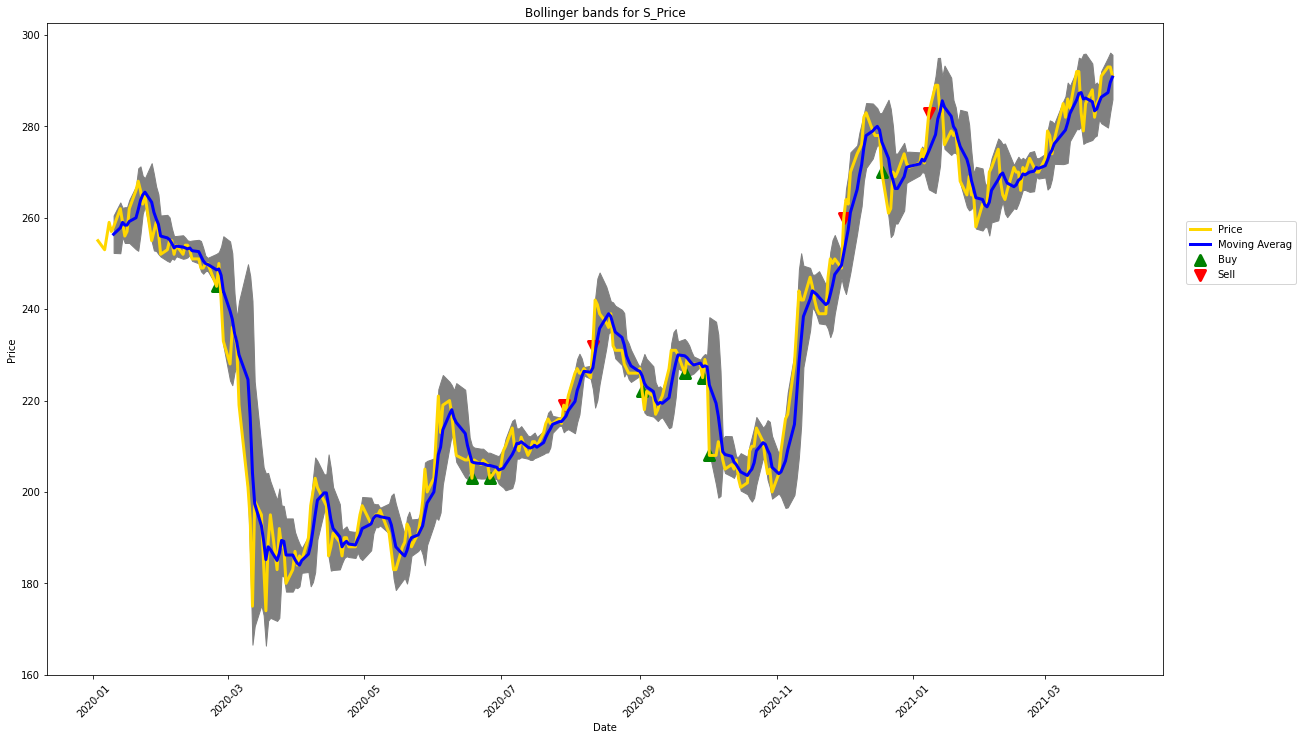

In [137]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

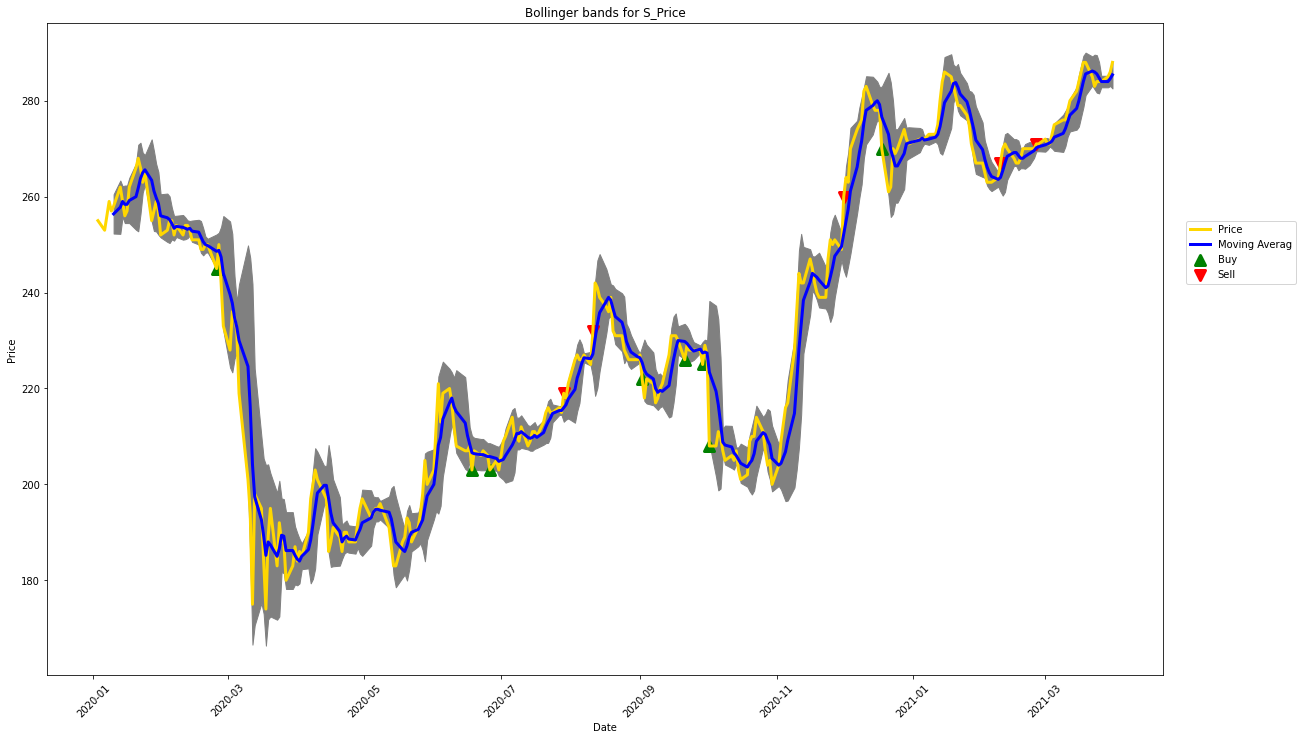

In [138]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'S_Price', p = 5, std = 1.7)

In [139]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = predictions_df['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 6.14%


#### KCHOL Stock

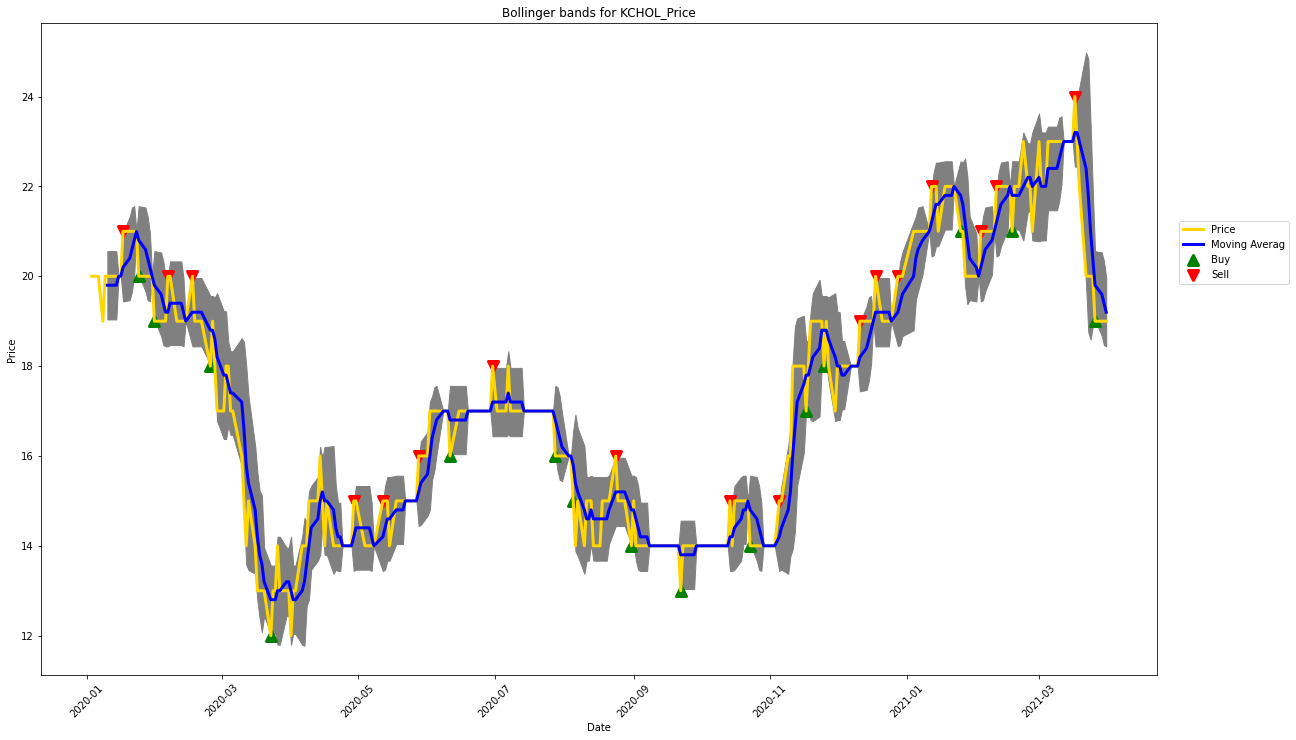

In [140]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

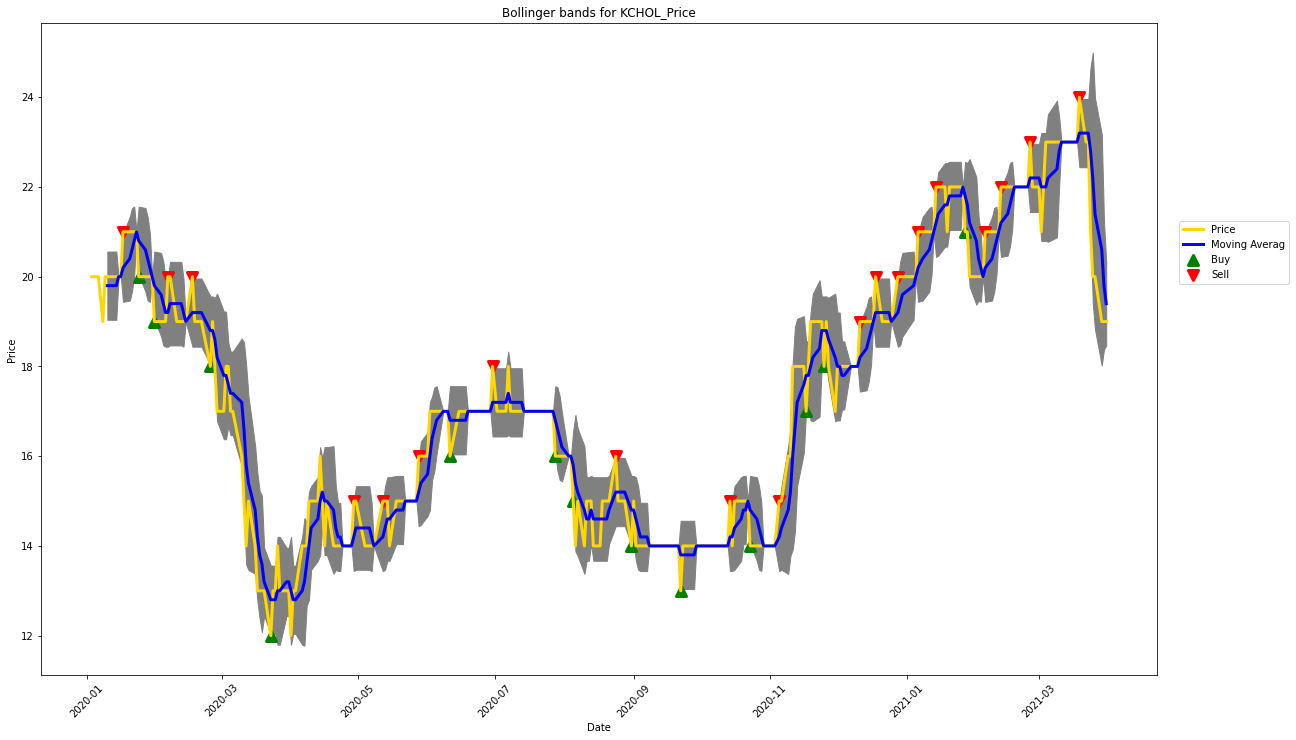

In [141]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'KCHOL_Price', p = 5, std = 1.7)

In [142]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = predictions_df['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -6.54%


#### M Stock

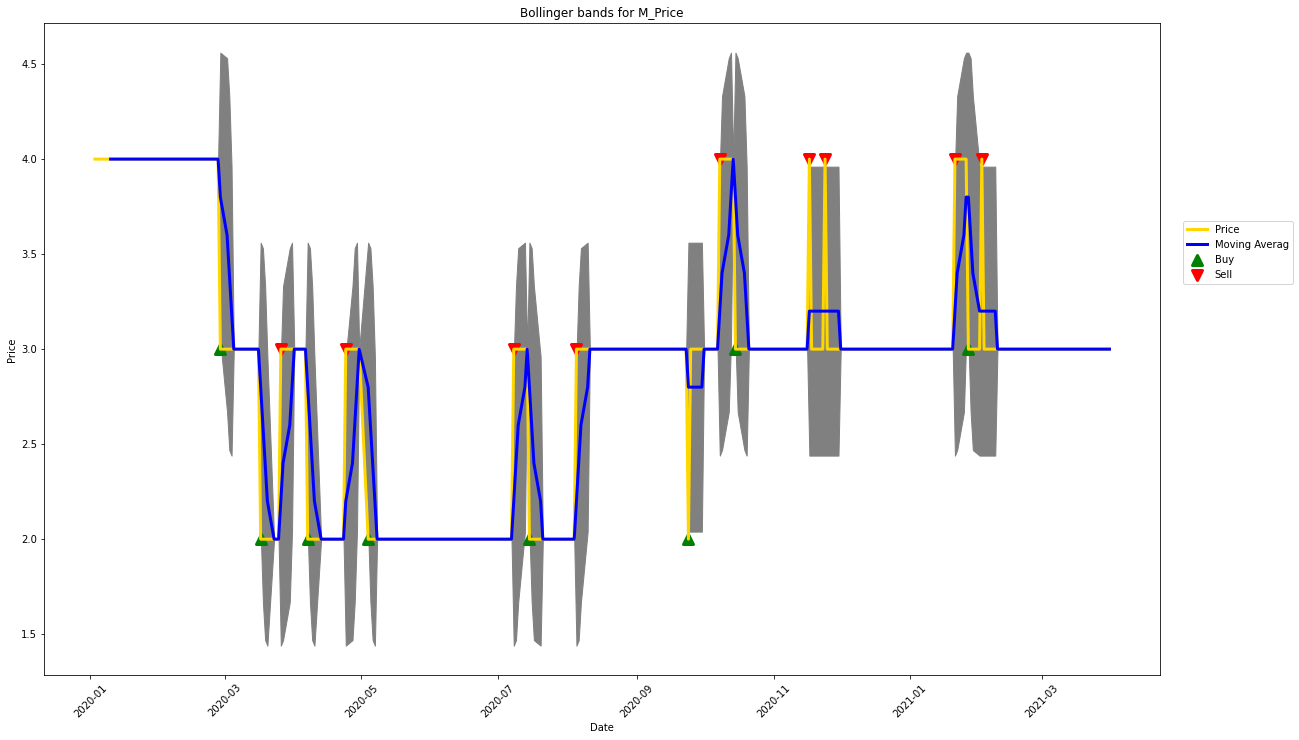

In [143]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

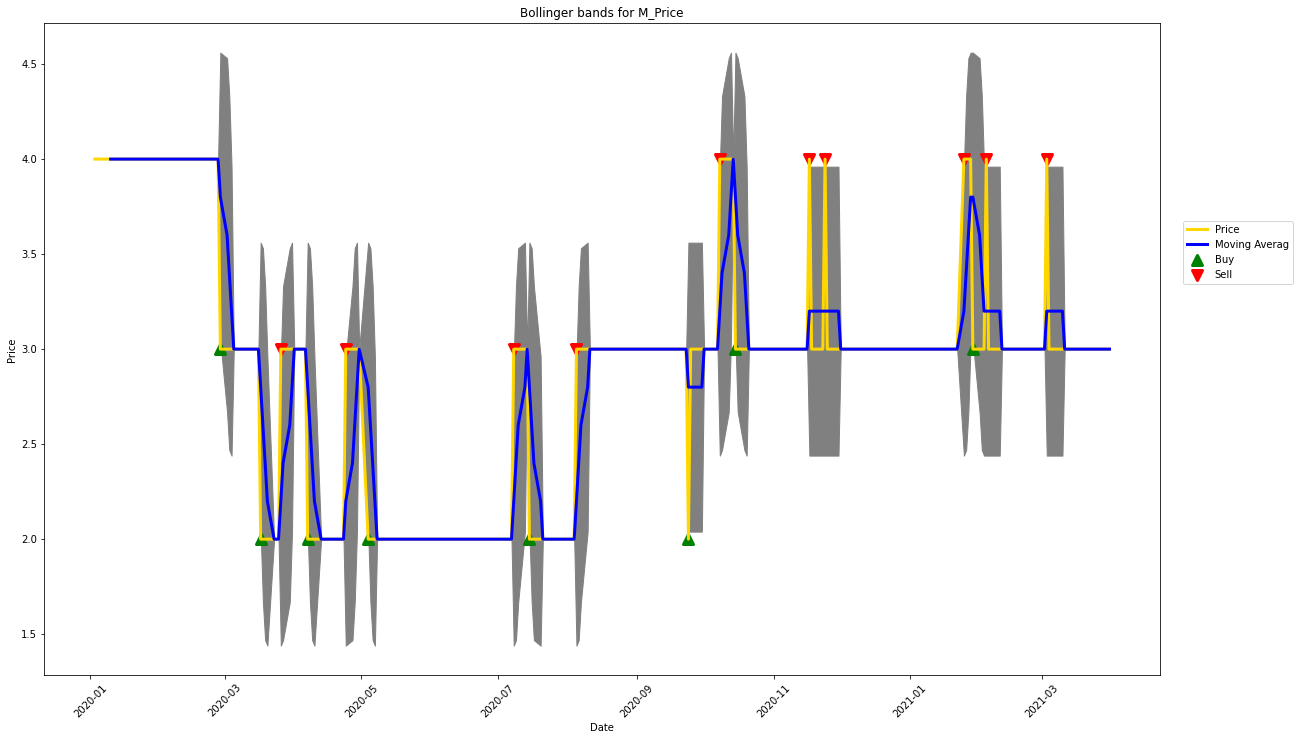

In [144]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'M_Price', p = 5, std = 1.7)

In [145]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = predictions_df['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -1.13%


#### BEEF Stock

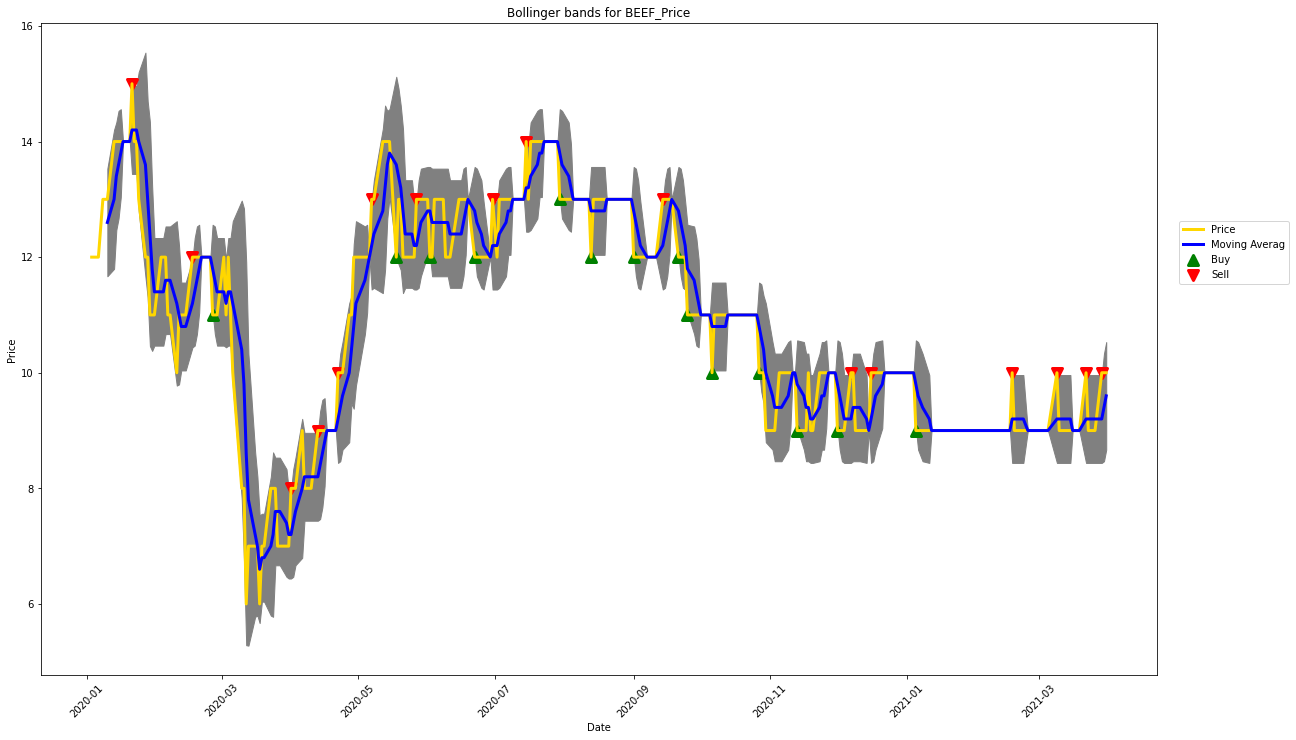

In [146]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

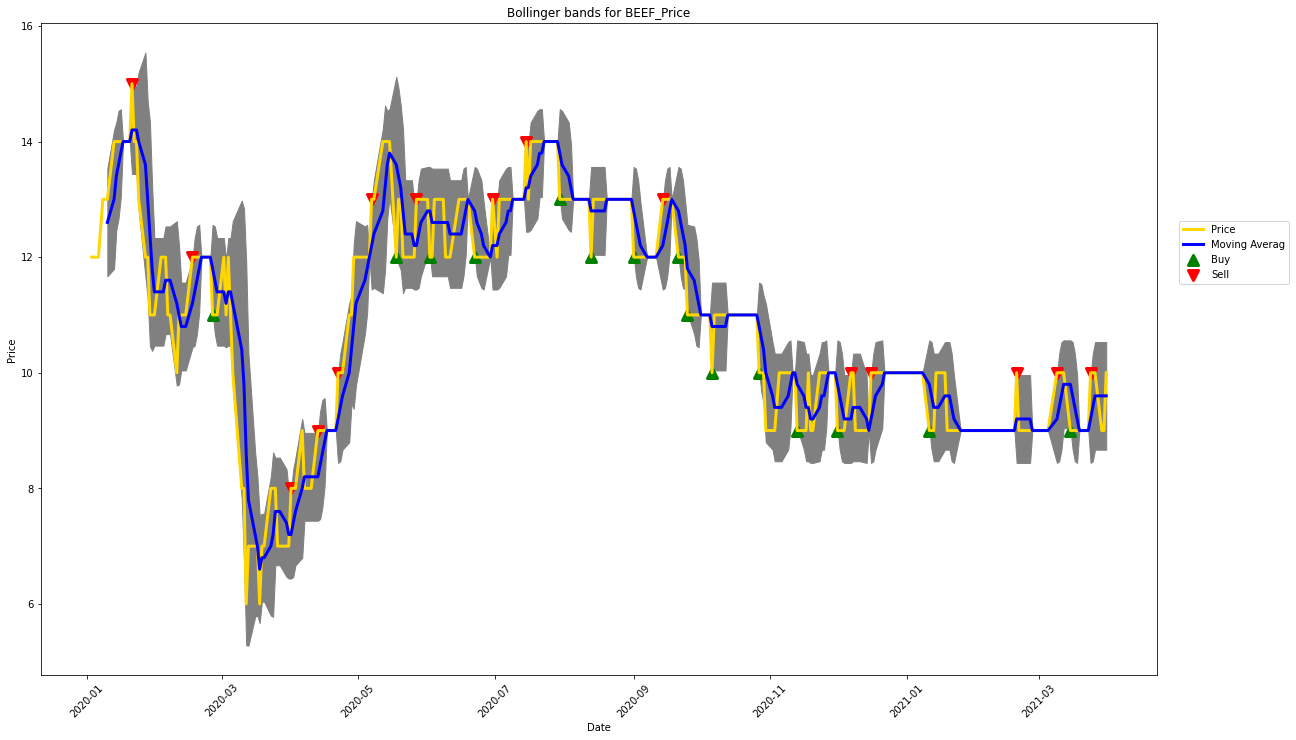

In [147]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'BEEF_Price', p = 5, std = 1.7)

In [148]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = predictions_df['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value -0.26%


#### P Stock

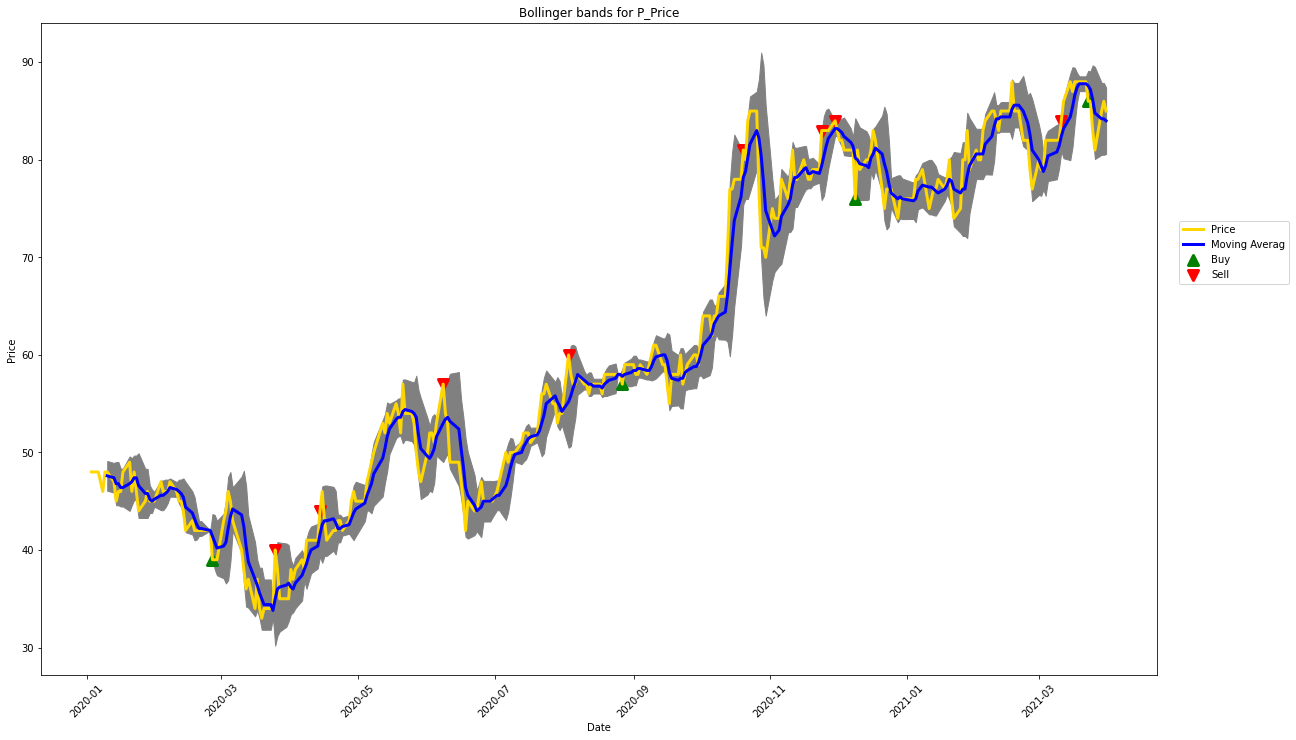

In [149]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

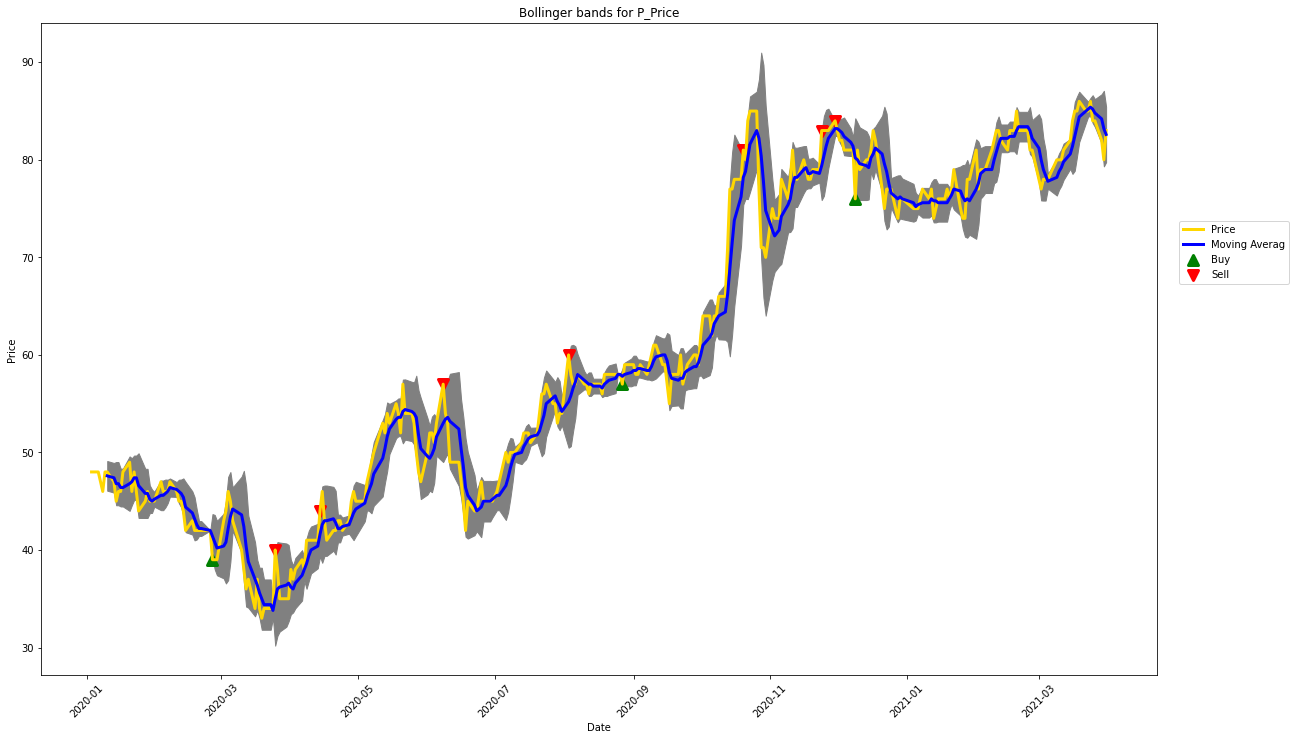

In [150]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'P_Price', p = 5, std = 1.7)

In [151]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = predictions_df['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 9.97%


#### C Stock

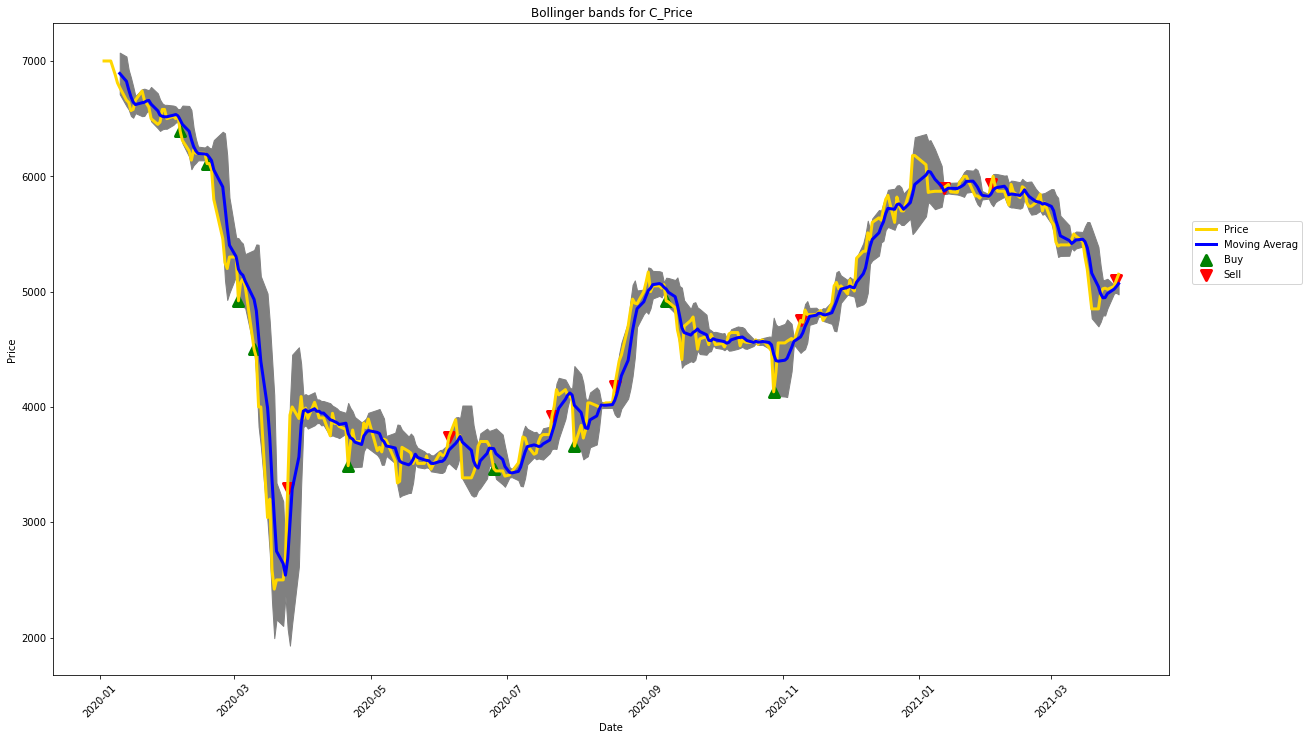

In [152]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

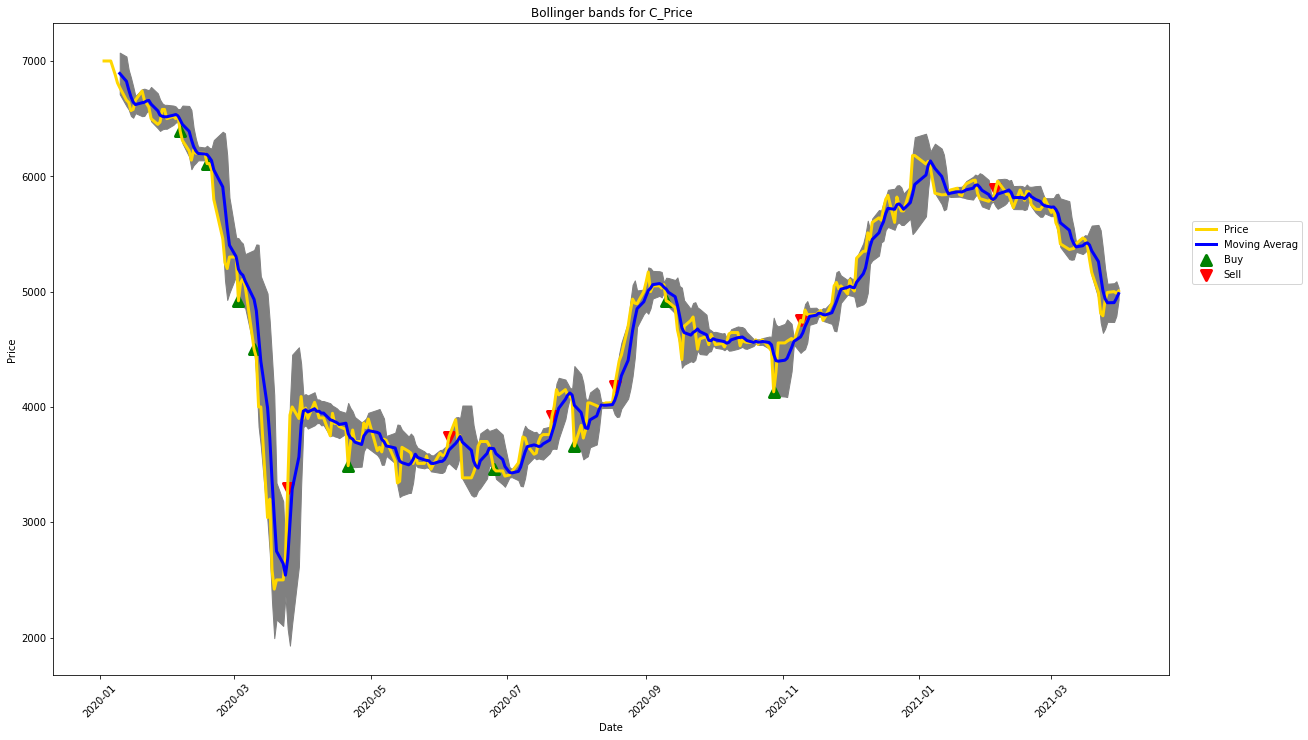

In [153]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'C_Price', p = 5, std = 1.7)

In [154]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = predictions_df['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -18.02%


#### IP Stock

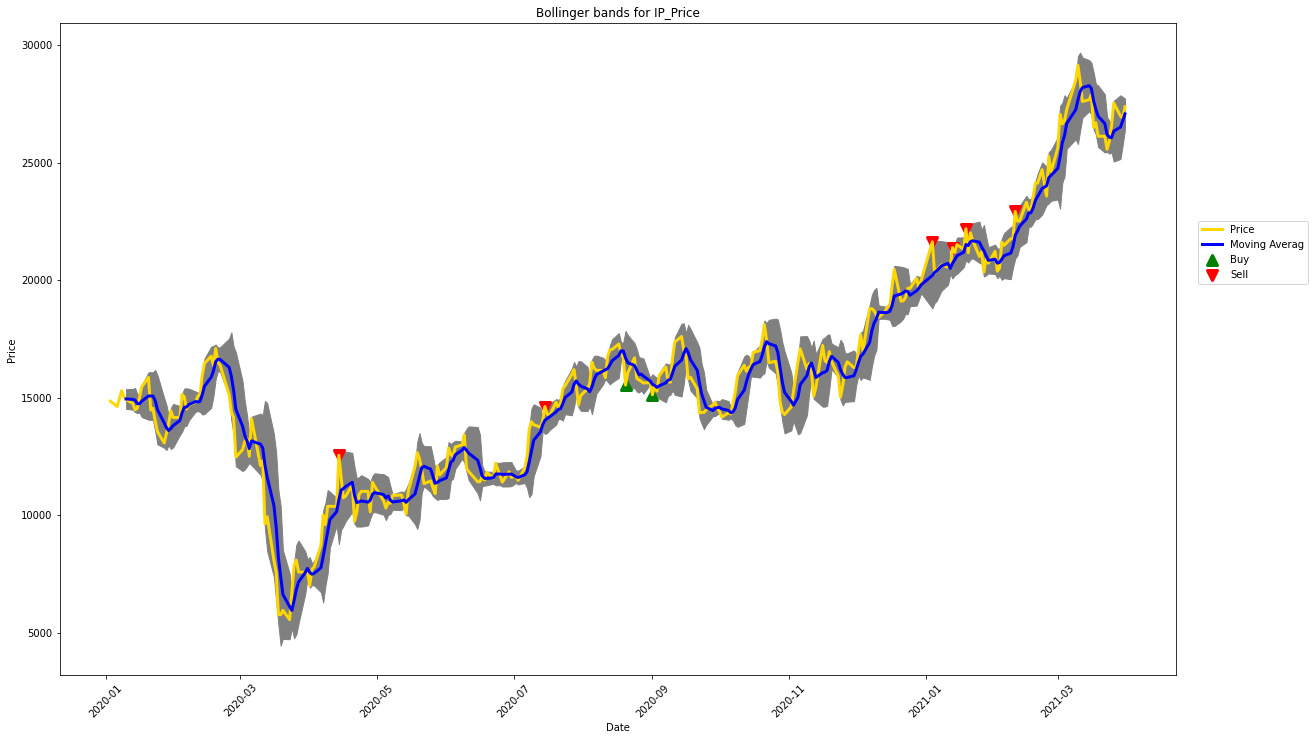

In [155]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

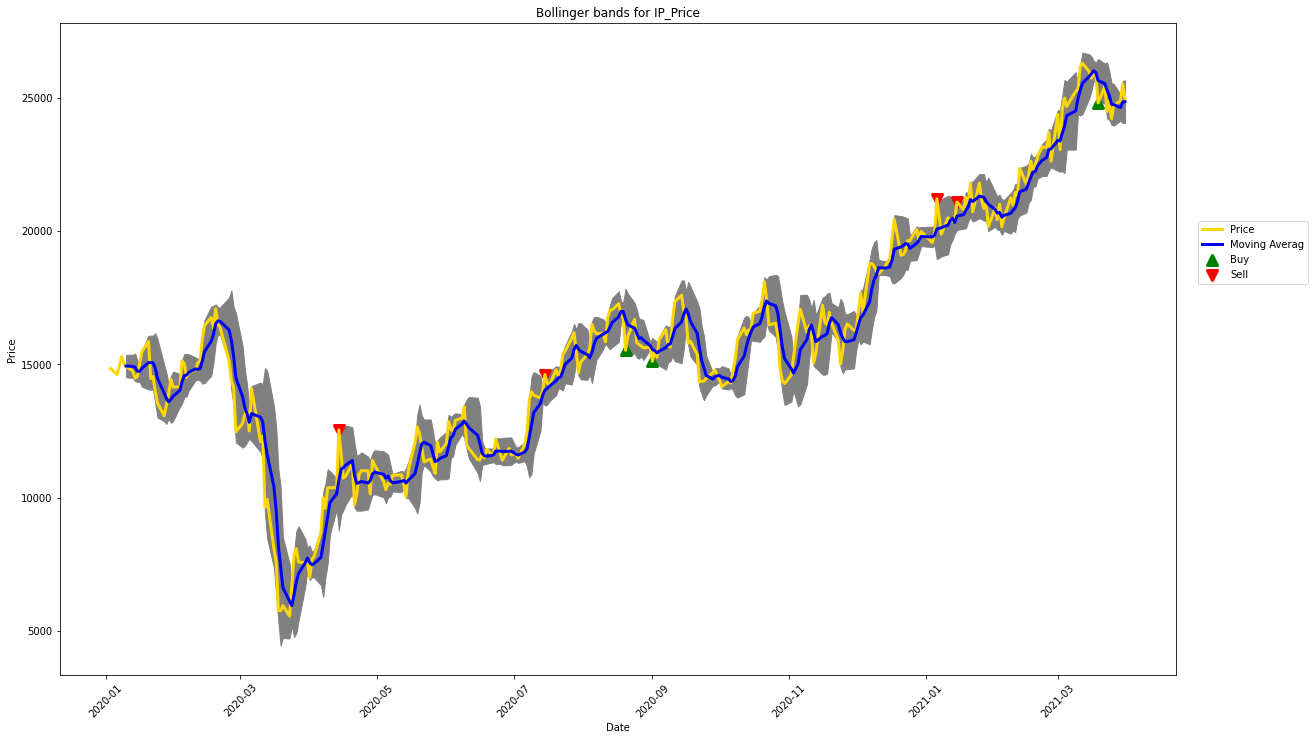

In [156]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'IP_Price', p = 5, std = 1.7)

In [157]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = predictions_df['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 27.55%


#### DS Stock

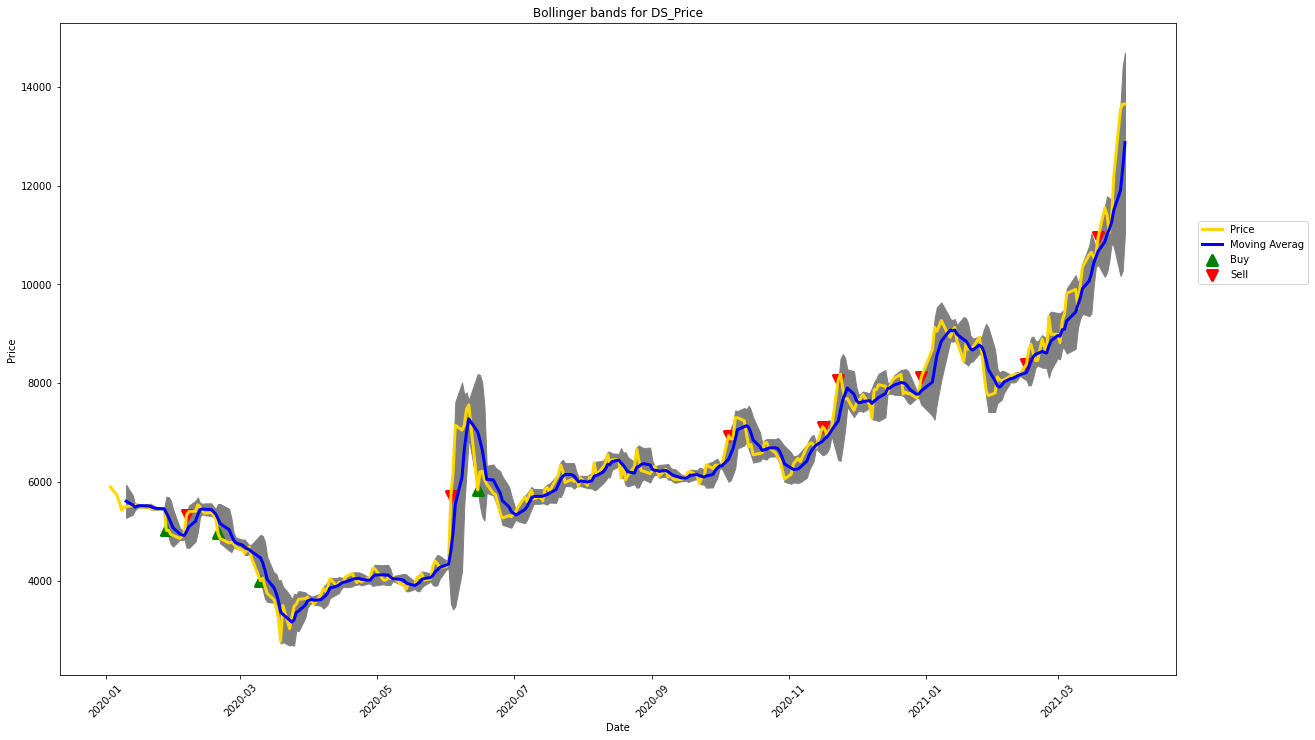

In [158]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

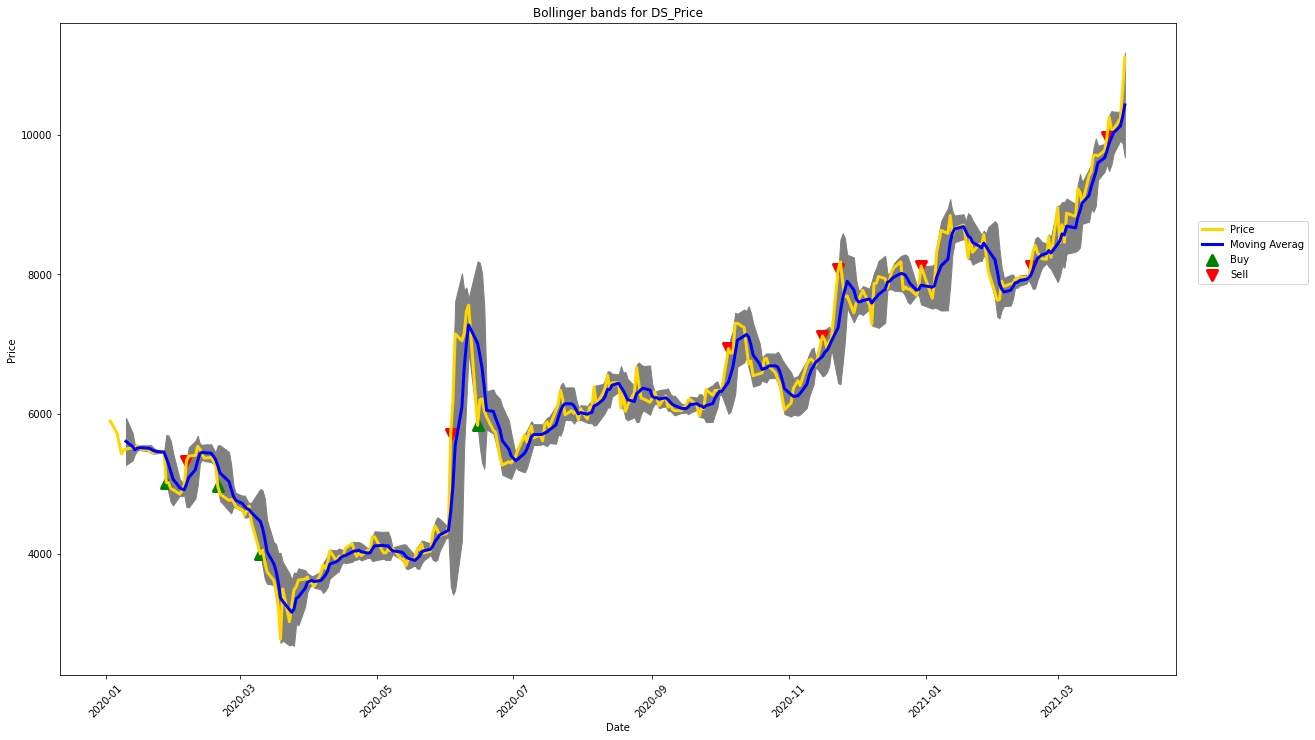

In [159]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'DS_Price', p = 5, std = 1.7)

In [160]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = predictions_df['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 45.04%


### ARIMA

In [161]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df_arima = merge_df(df1 = S_predicted_arima, df2 = KCHOL_predicted_arima, df3 = M_predicted_arima, 
                        df4 = BEEF_predicted_arima, df5 = P_predicted_arima, df6 = C_predicted_arima, 
                        df7 = IP_predicted_arima, df8 = DS_predicted_arima)

#### S Stock

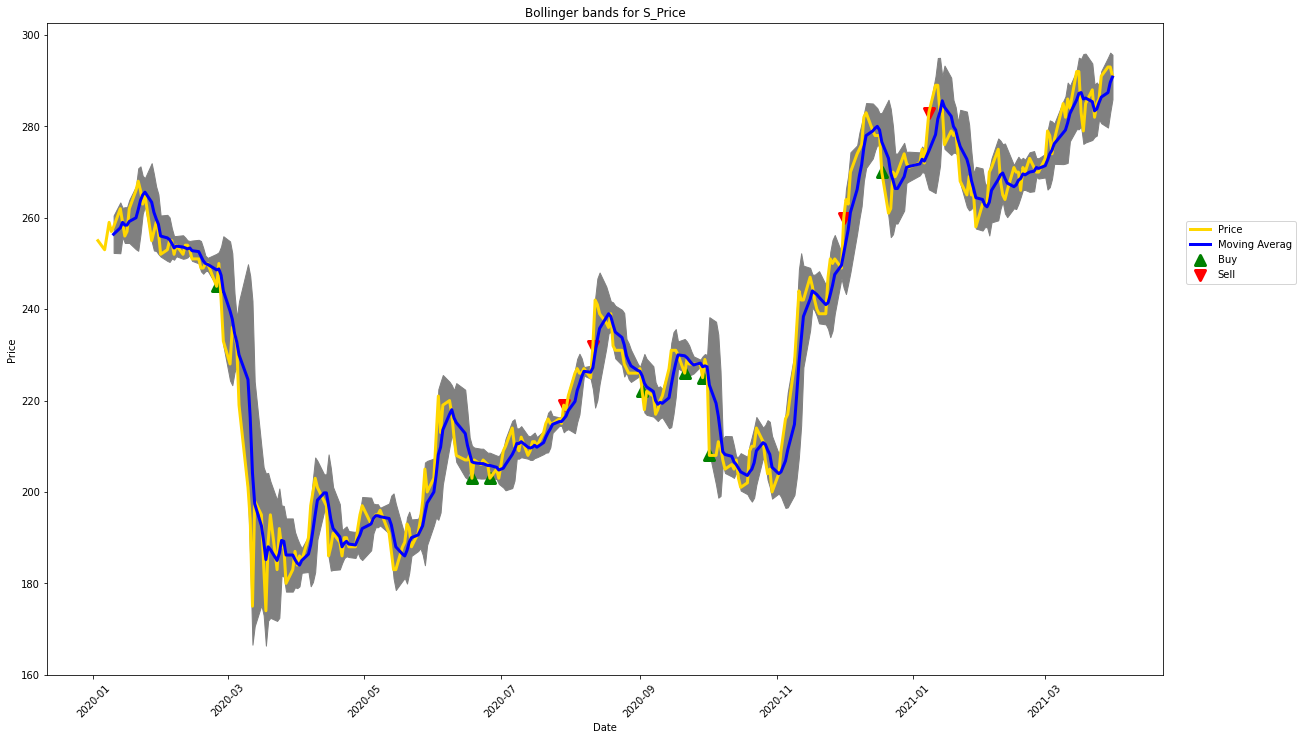

In [162]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

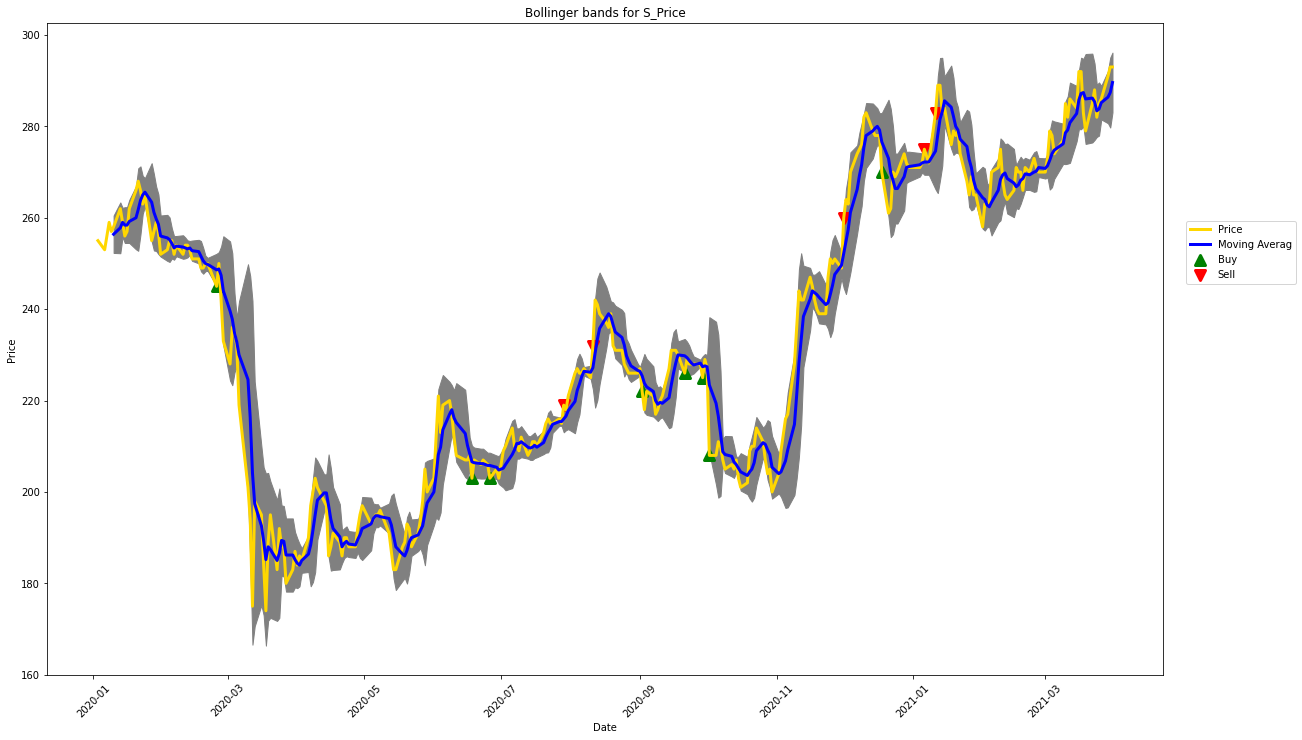

In [163]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'S_Price', p = 5, std = 1.7)

In [164]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = pred_arima['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 7.95%


#### KCHOL Stock

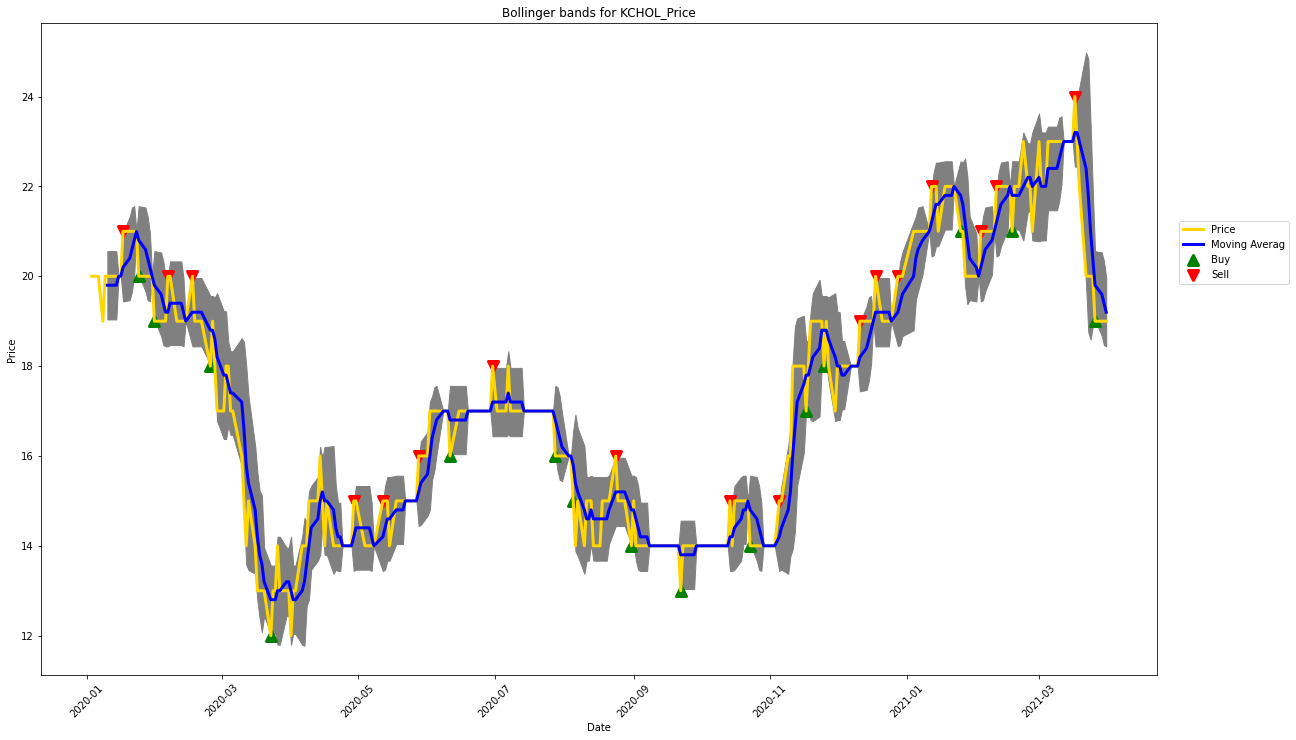

In [165]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

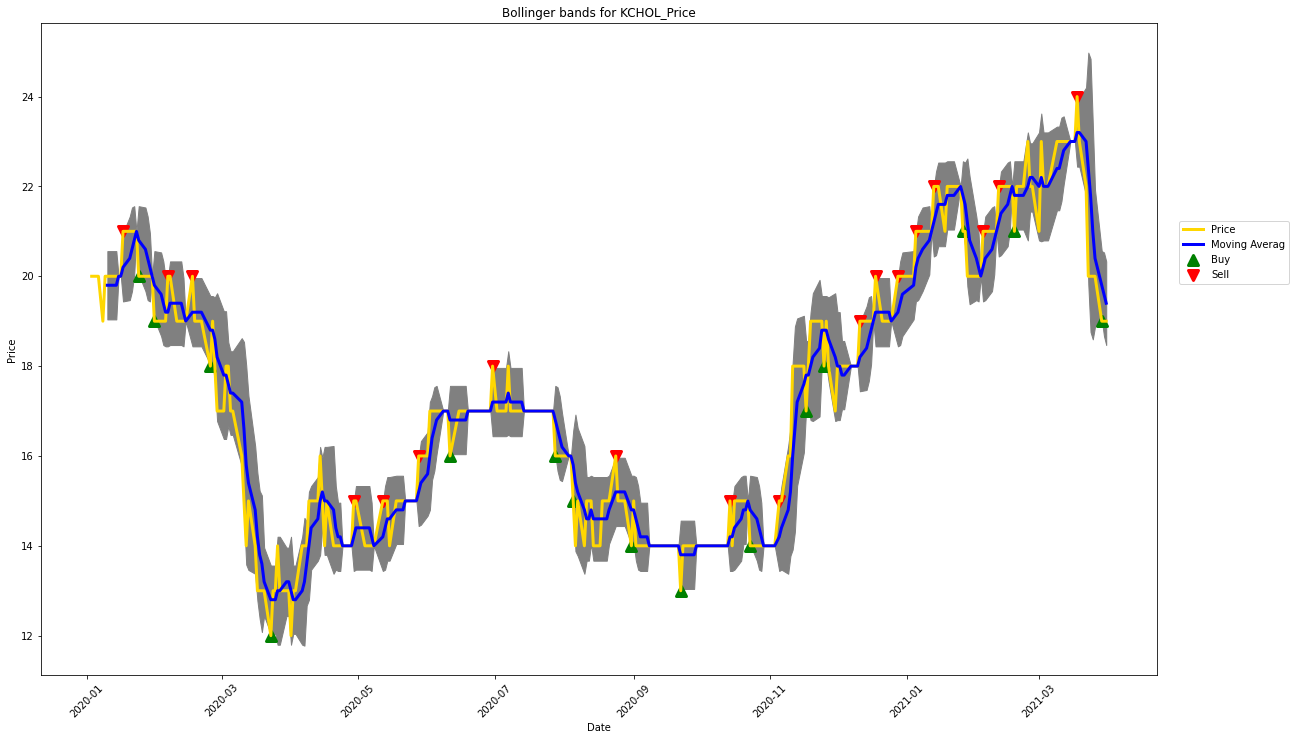

In [166]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'KCHOL_Price', p = 5, std = 1.7)

In [167]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = pred_arima['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -6.88%


#### M Stock

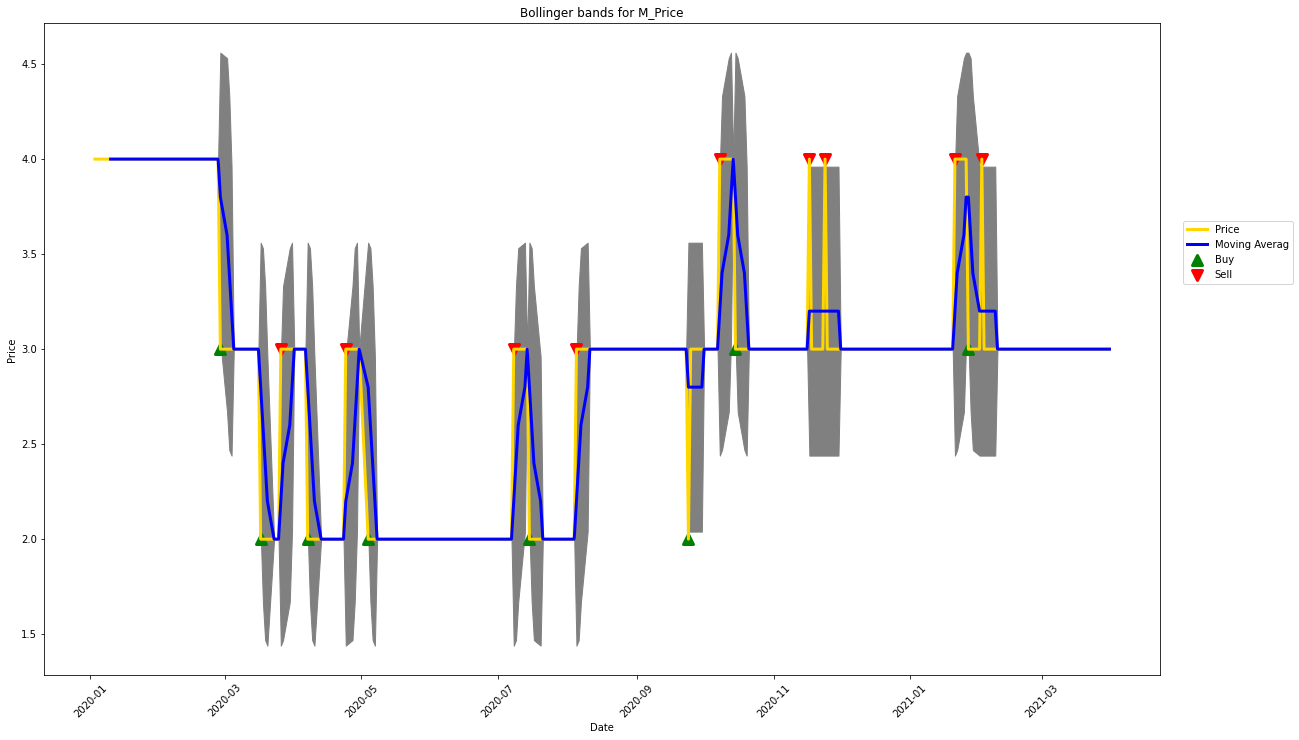

In [168]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

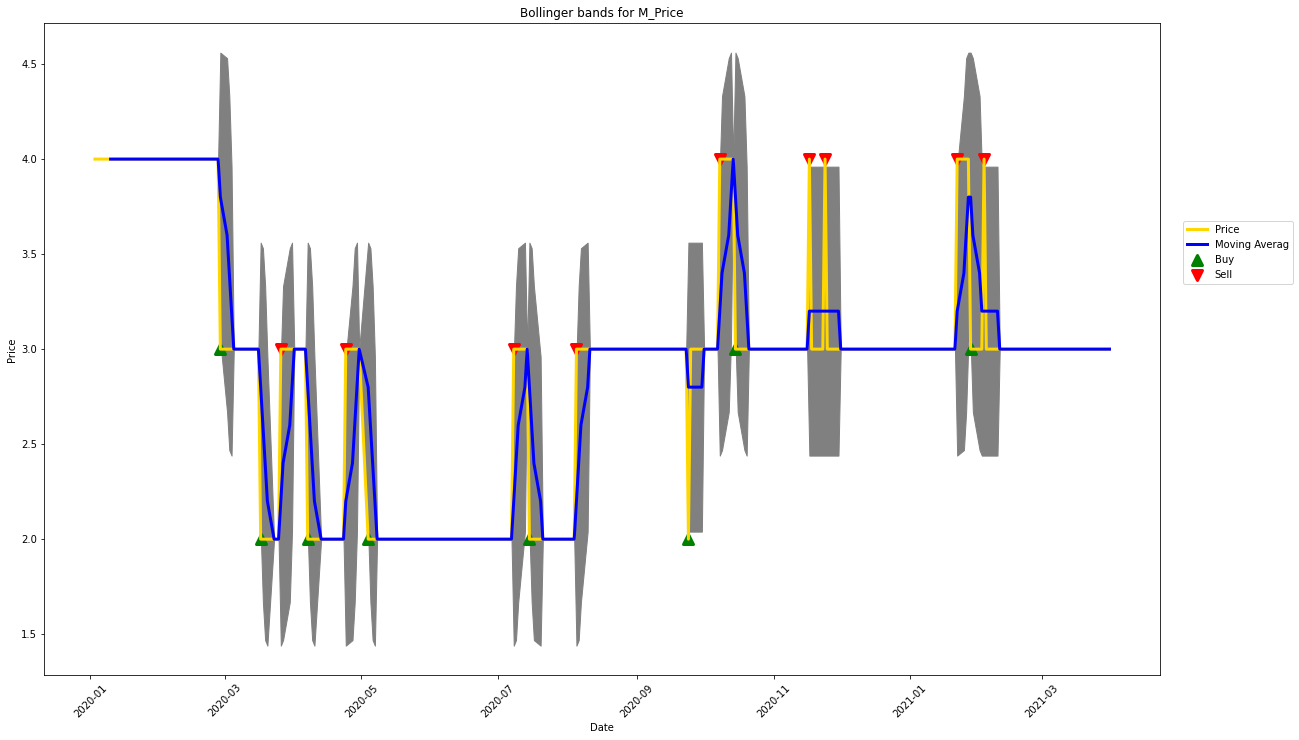

In [169]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'M_Price', p = 5, std = 1.7)

In [170]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = pred_arima['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -2.51%


#### BEEF Stock

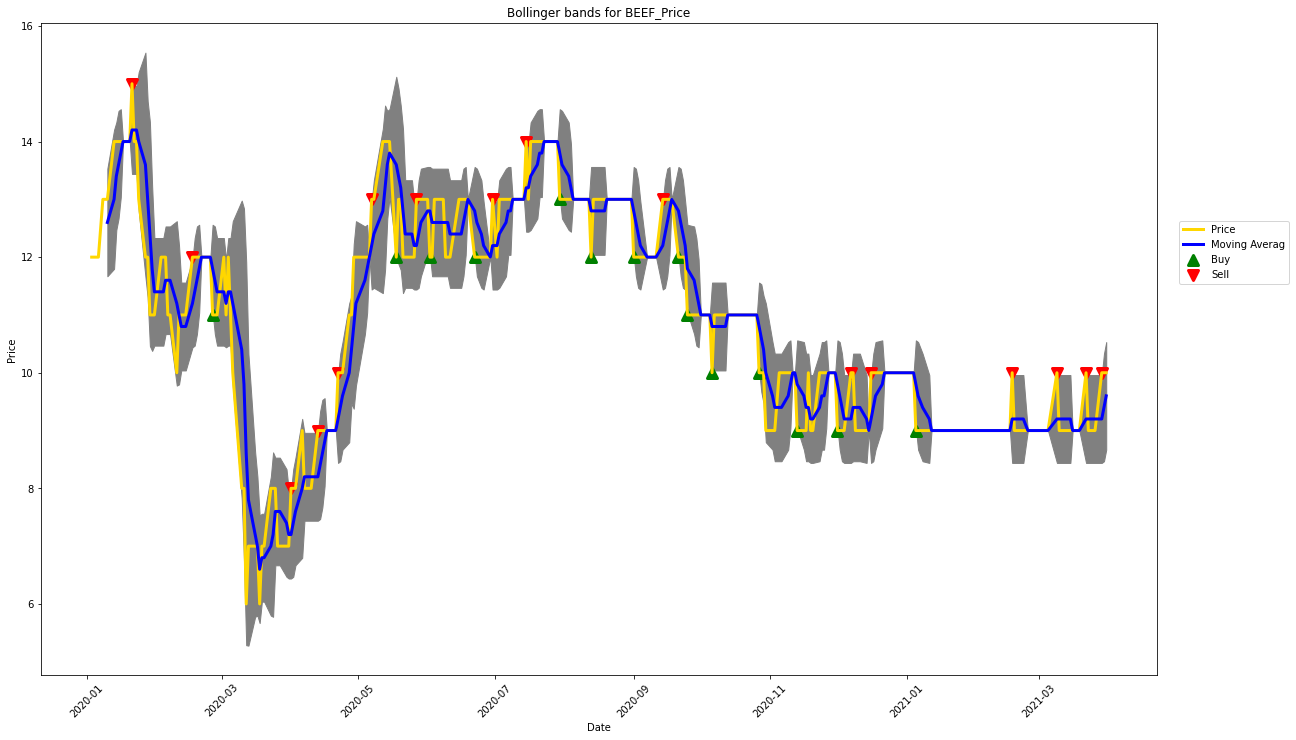

In [171]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

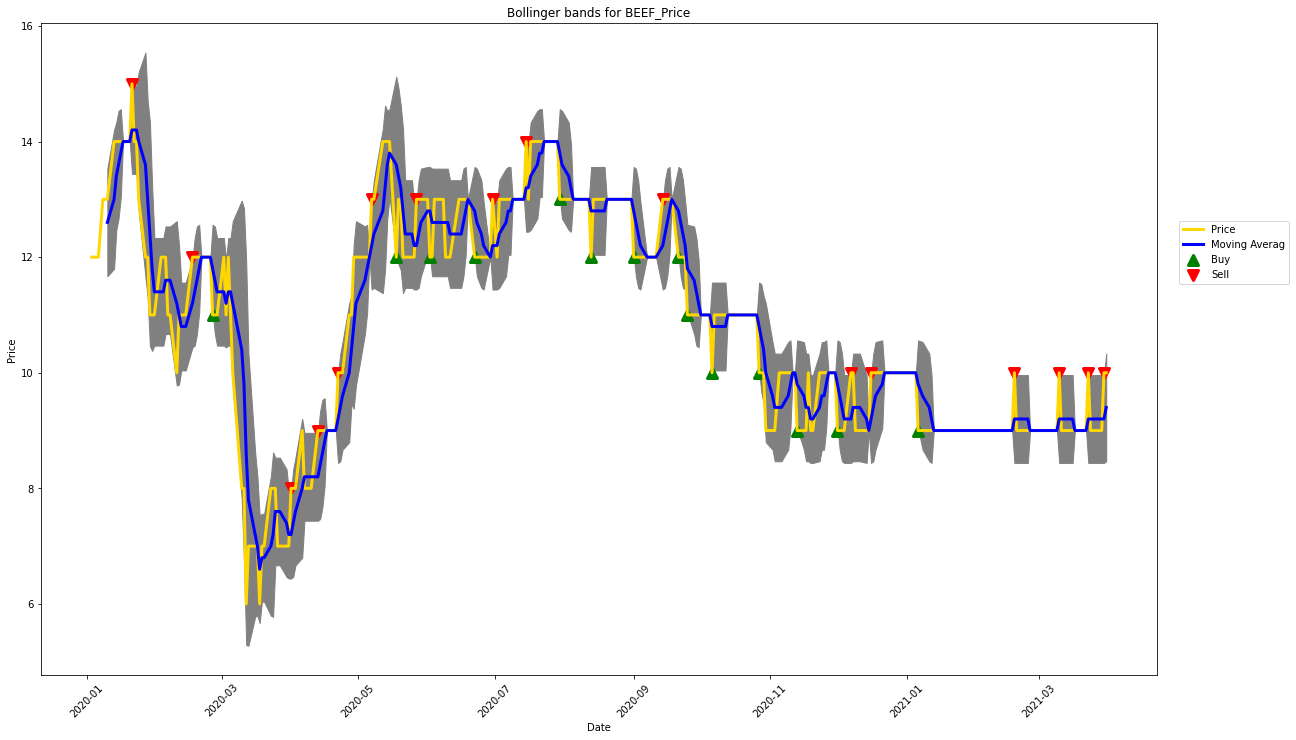

In [172]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'BEEF_Price', p = 5, std = 1.7)

In [173]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = pred_arima['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value 1.77%


#### P Stock

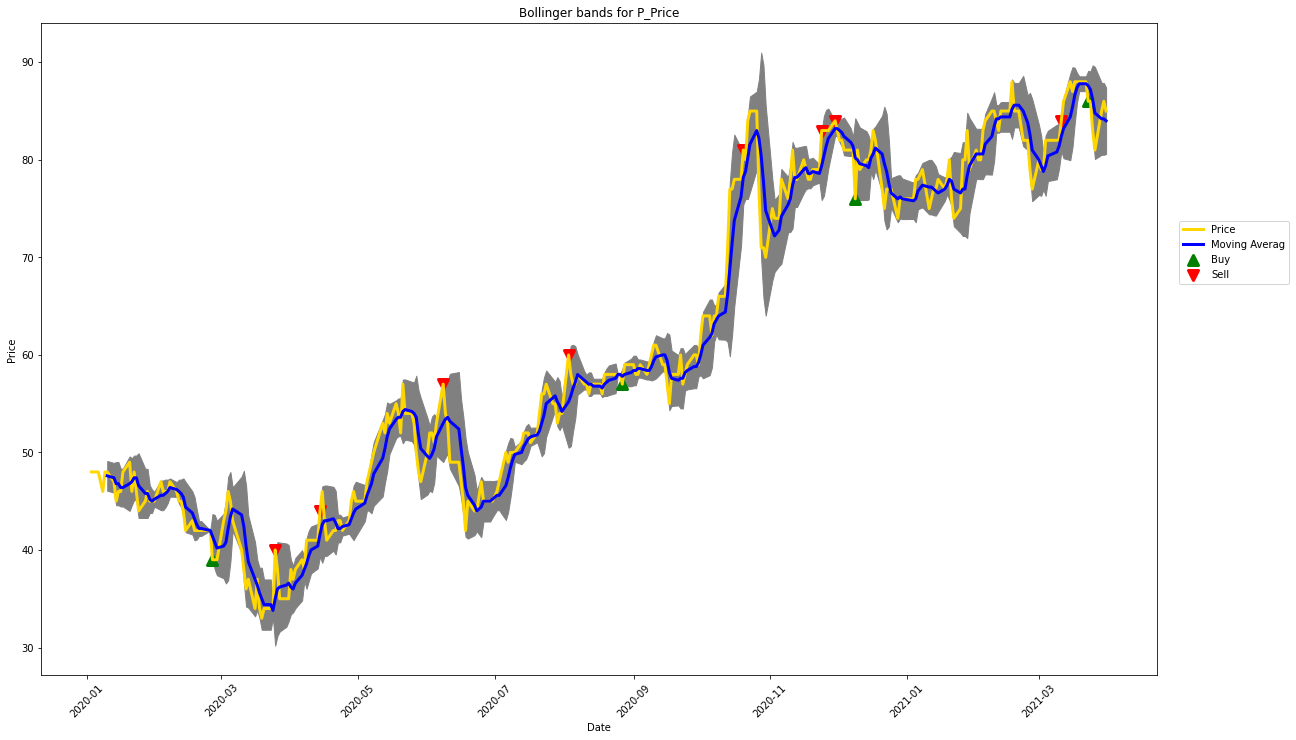

In [174]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

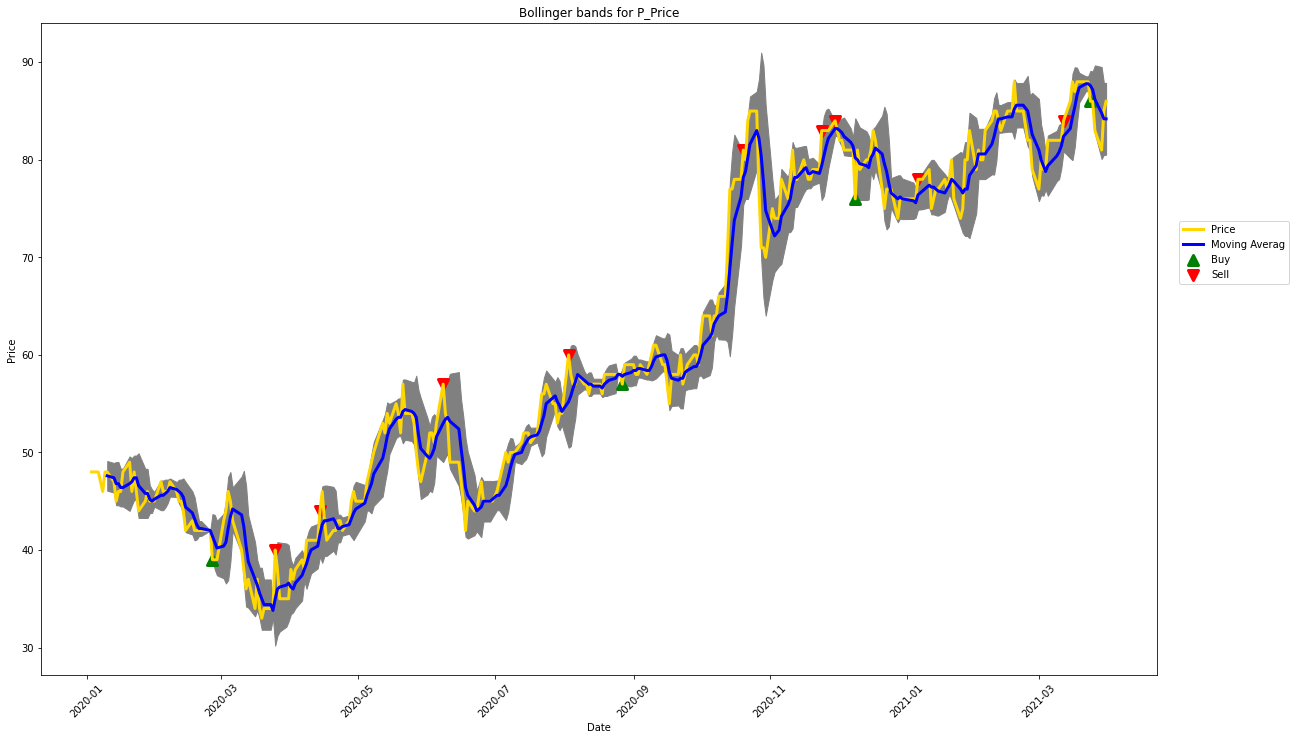

In [175]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'P_Price', p = 5, std = 1.7)

In [176]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = pred_arima['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 11.96%


#### C Stock

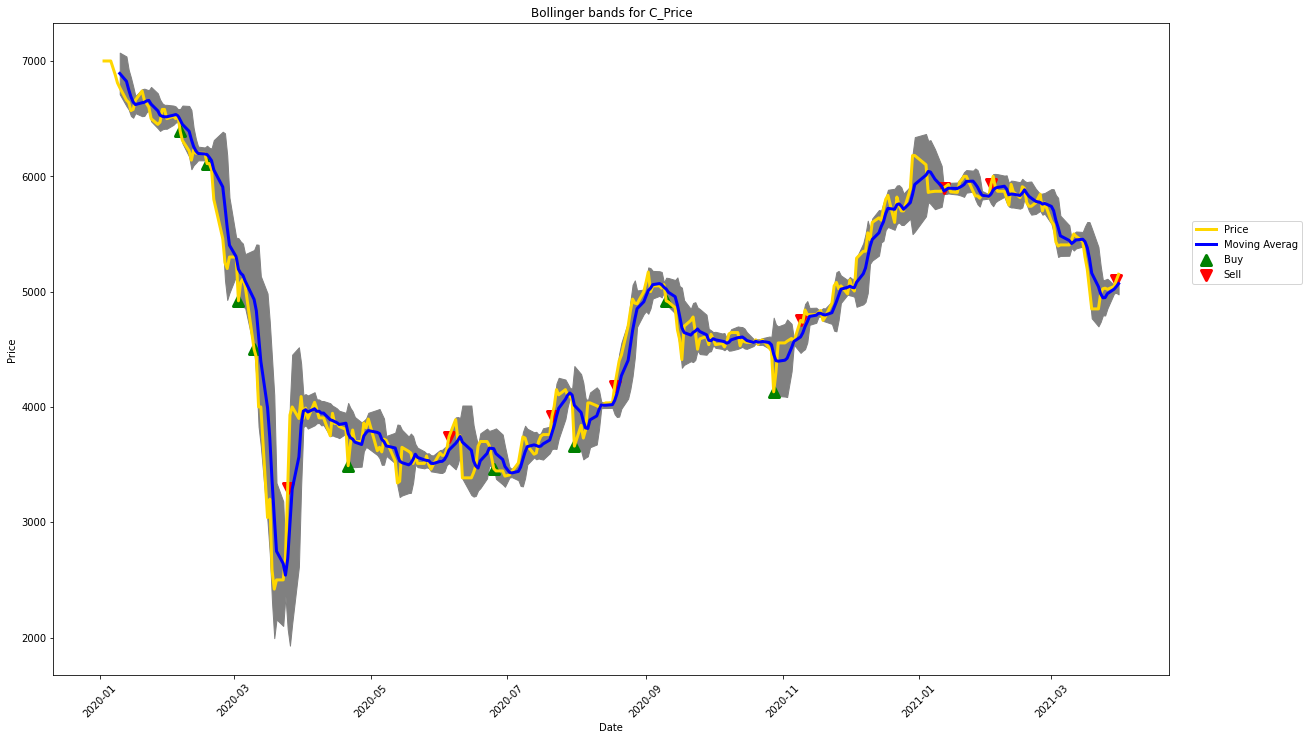

In [177]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

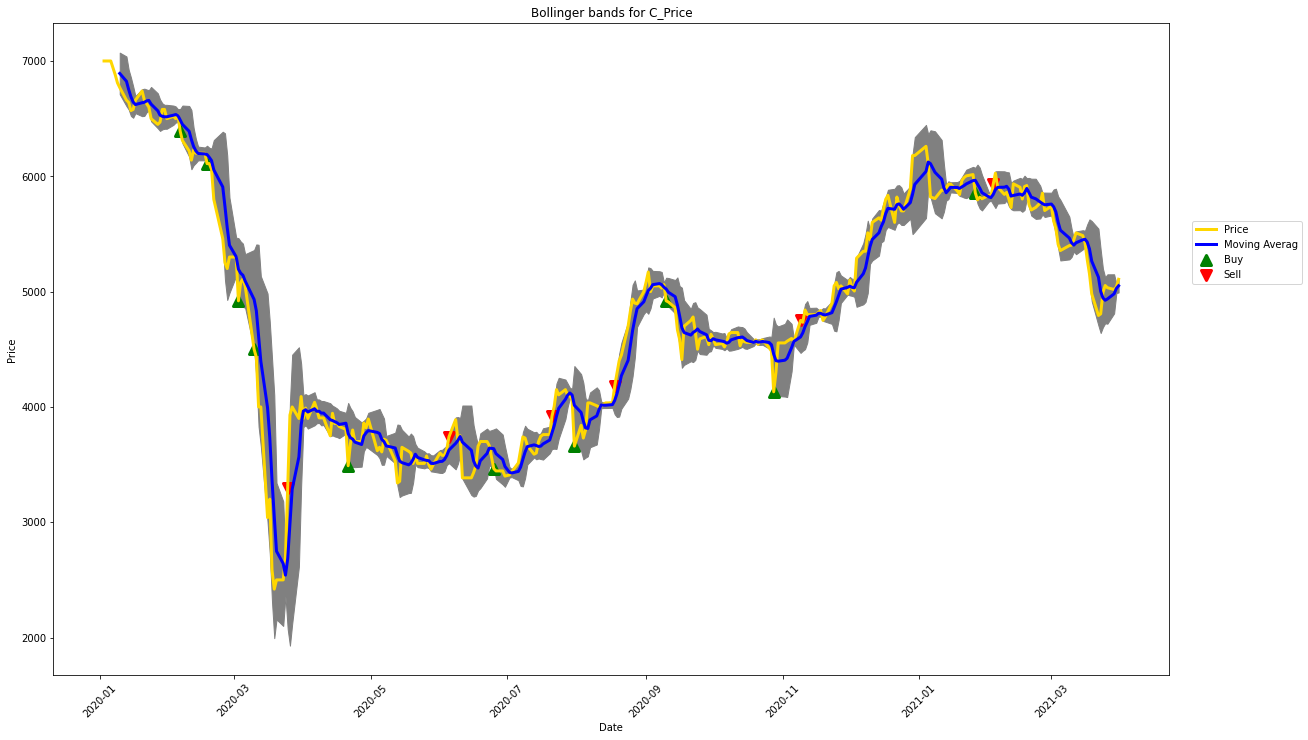

In [178]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'C_Price', p = 5, std = 1.7)

In [179]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = pred_arima['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -18.42%


#### IP Stock

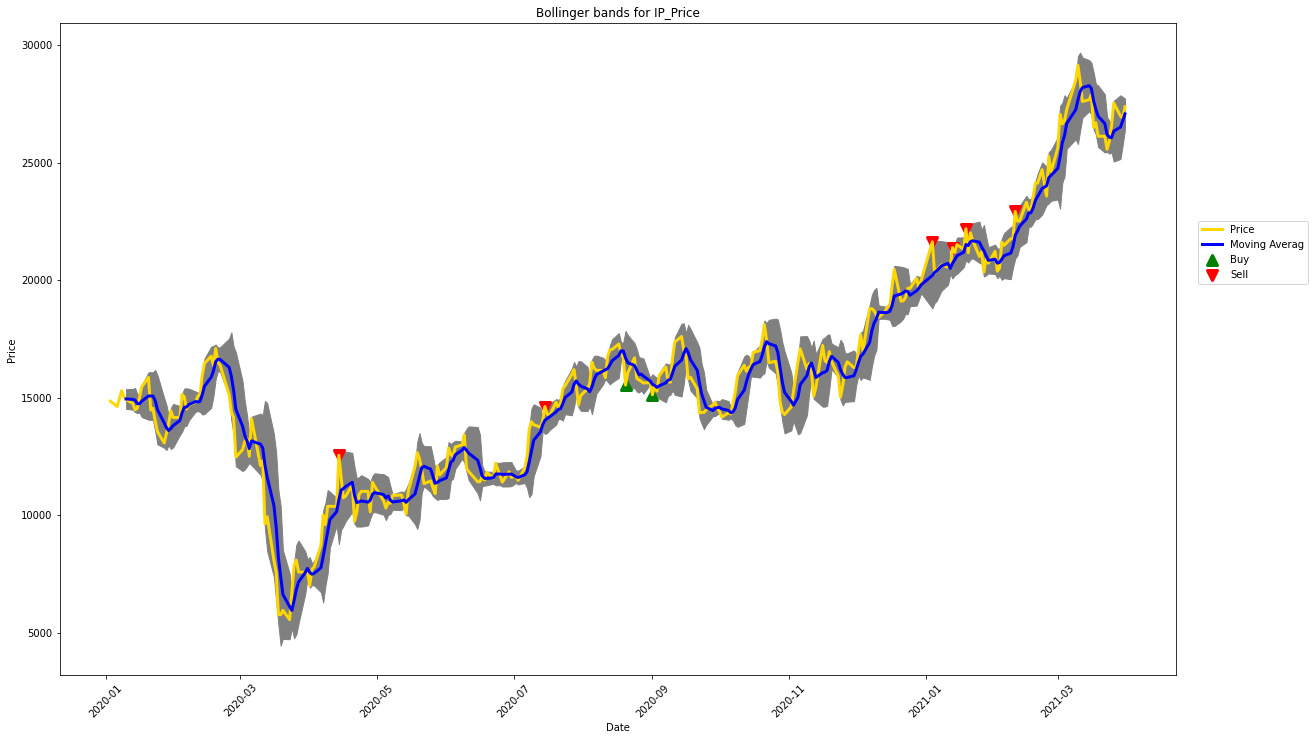

In [180]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

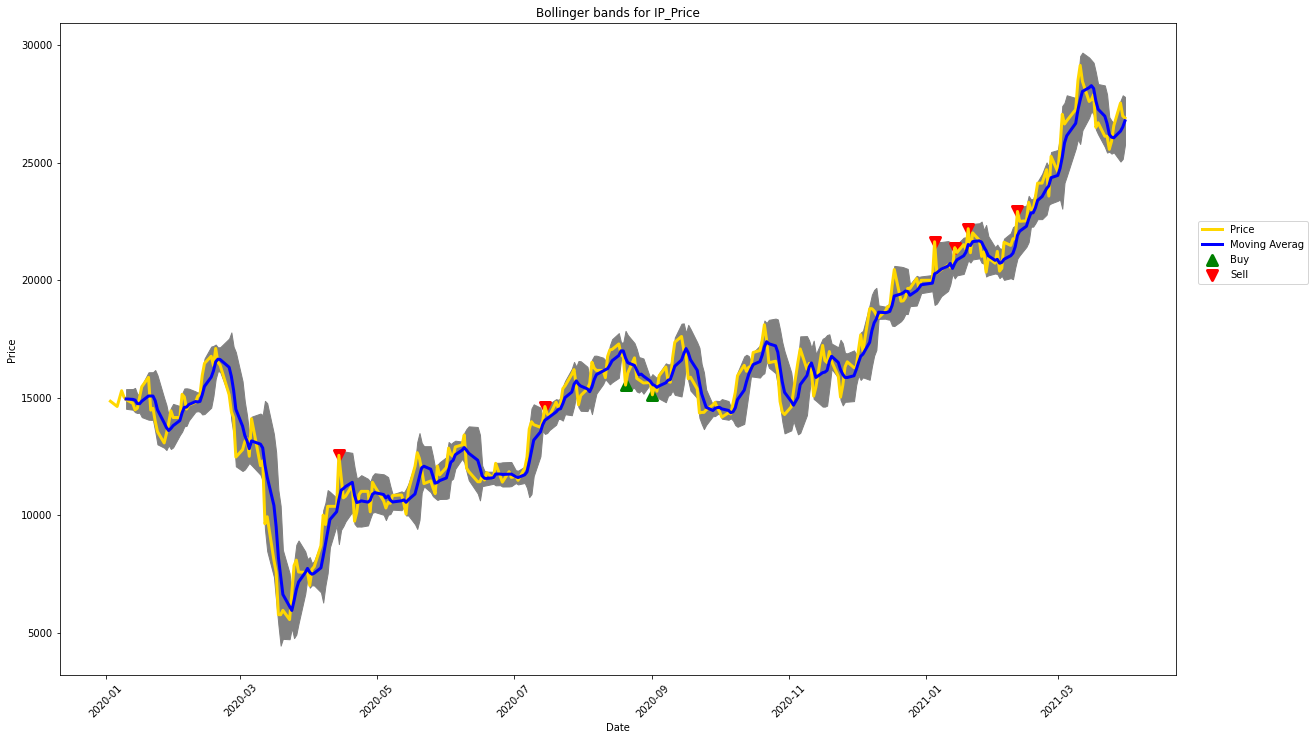

In [181]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'IP_Price', p = 5, std = 1.7)

In [182]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = pred_arima['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 34.56%


#### DS Stock

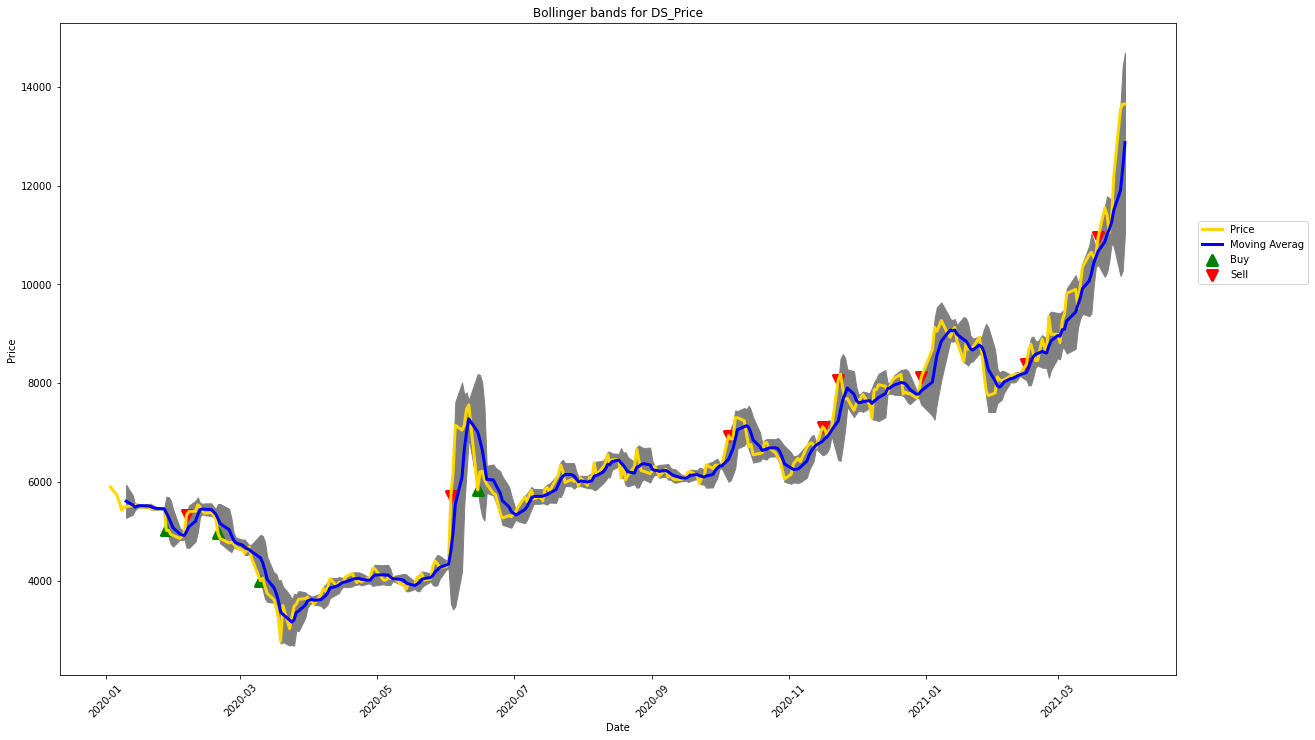

In [183]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

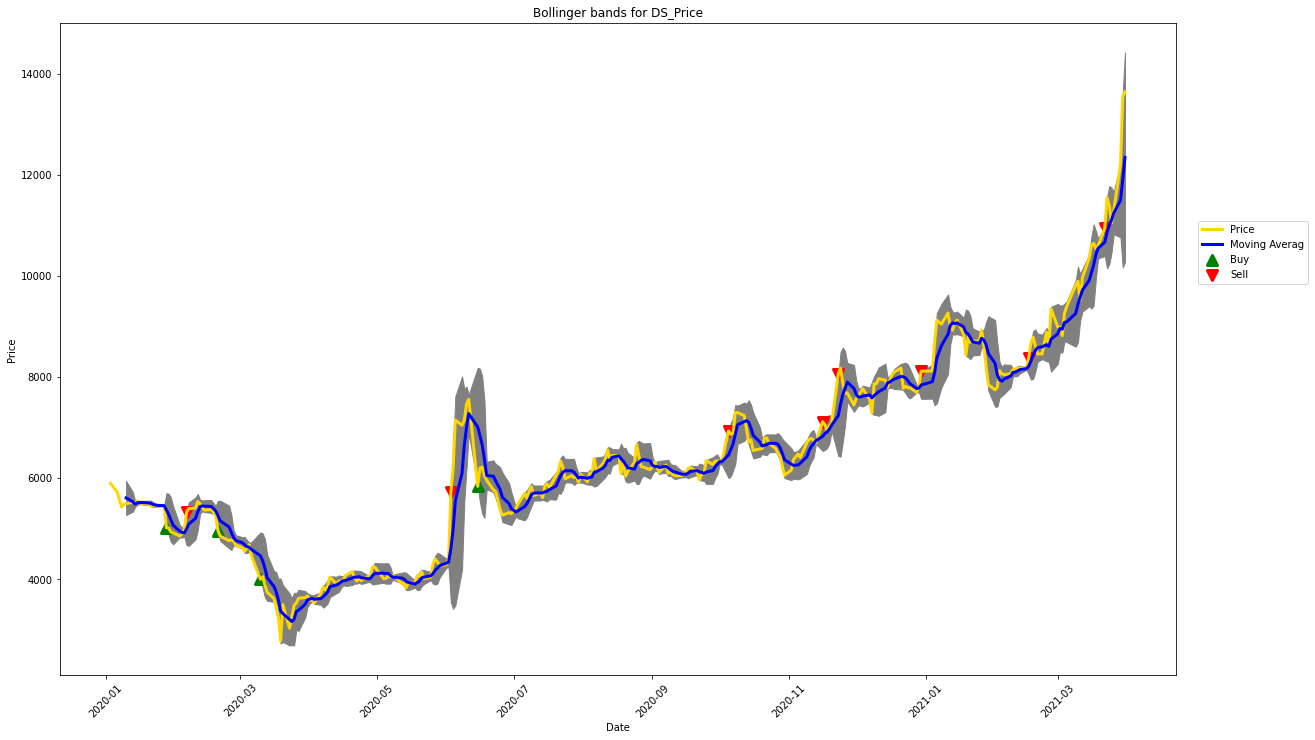

In [184]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'DS_Price', p = 5, std = 1.7)

In [185]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = pred_arima['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 68.1%


### Combining two models

In [186]:
from sklearn.metrics import mean_squared_error

In [187]:
def model_weight(col):
    x = np.arange(0,1.1, 0.1)
    y = np.arange(0,1.1, 0.1)
    squared_error = []
    weights_lstm = []
    weights_arima = []
    for i in x:
        for j in y:
            if (i+j) ==1:
                p = (i*predictions_df[col])+(j*pred_arima[col])
                e = mean_squared_error(test[col], p)
                squared_error.append(e)
                weights_lstm.append(i)
                weights_arima.append(j)
                
            else:
                pass
    return squared_error, weights_lstm, weights_arima

In [188]:
def pred_df(col):
    pred = pd.concat([train[col], weighted_predictions[col]])
    return pred

In [189]:
# The combination of the two models by weigthing the results per 0.5. 
# Didn't take approach of mean squared error because it would show to use only ARIMA

weighted_predictions = (0.5 * predictions_df) + (0.5 * pred_arima)

#### D Stock

In [190]:
# New predictions

S_predictions = pred_df(col = 'S_Price')

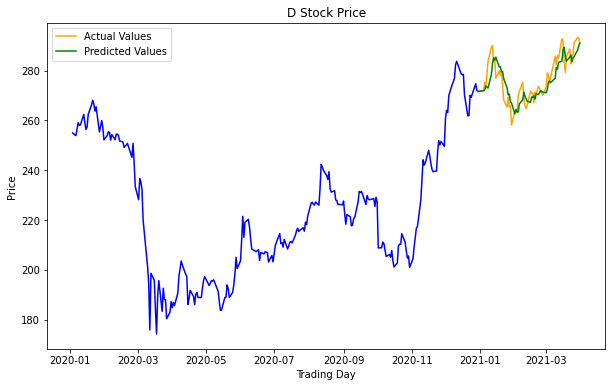

In [191]:
# Plot the Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predictions, string = 'D Stock Price')

#### KCHOL Stock

In [192]:
# New predictions

KCHOL_predictions = pred_df(col = 'KCHOL_Price')

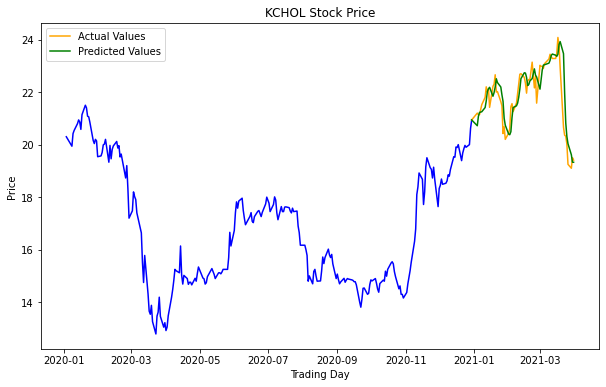

In [193]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predictions, string = 'KCHOL Stock Price')

#### M Stock

In [194]:
# New predictions

M_predictions = pred_df(col = 'M_Price')

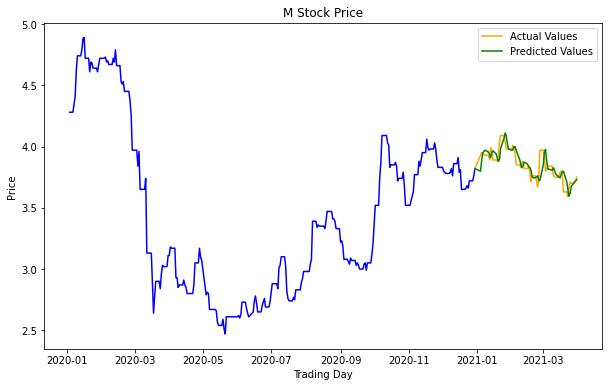

In [195]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predictions, string = 'M Stock Price')

#### BEEF Stock

In [196]:
# New predictions

BEEF_predictions = pred_df(col = 'BEEF_Price')

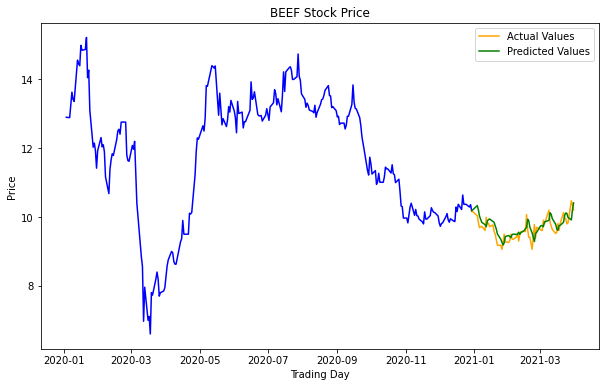

In [197]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predictions, string = 'BEEF Stock Price')

#### P Stock

In [198]:
# New predictions

P_predictions = pred_df(col = 'P_Price')

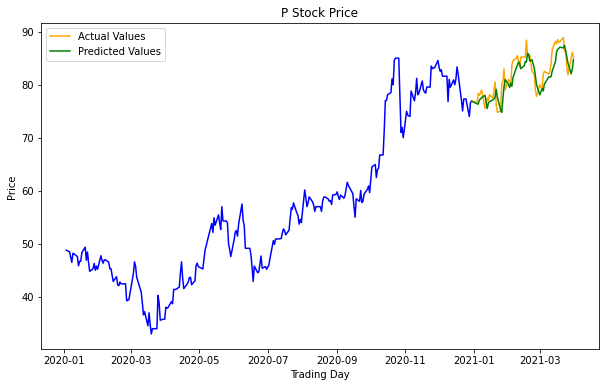

In [199]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predictions, string = 'P Stock Price')

#### C Stock

In [200]:
# New predictions

C_predictions = pred_df(col = 'C_Price')

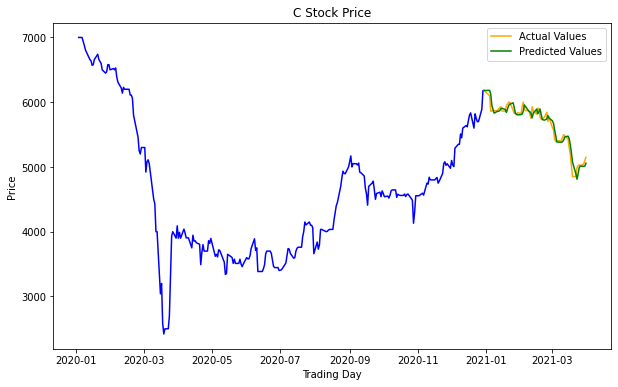

In [201]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predictions, string = 'C Stock Price')

#### IP Stock

In [202]:
# New predictions

IP_predictions = pred_df(col = 'IP_Price')

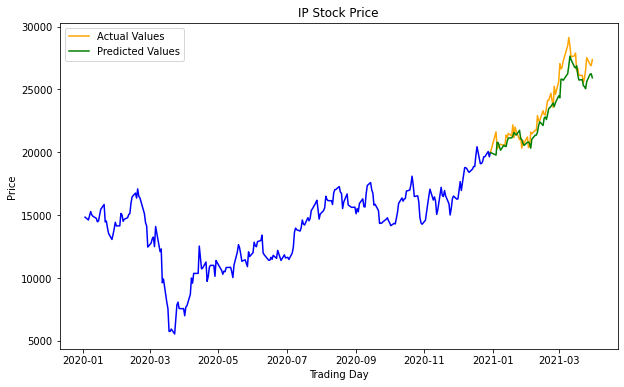

In [203]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predictions, string = 'IP Stock Price')

#### DS Stock

In [204]:
# New predictions

DS_predictions = pred_df(col = 'DS_Price')

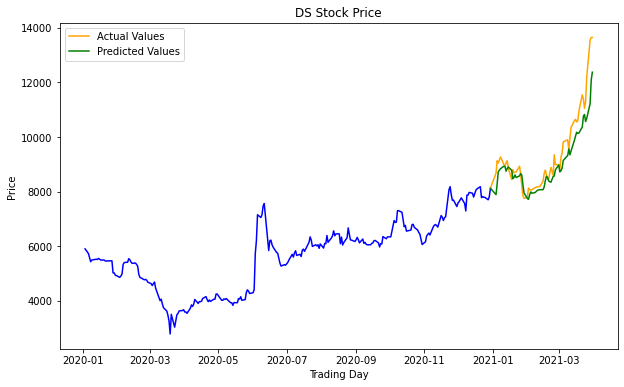

In [205]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predictions, string = 'DS Stock Price')

In [206]:
class model_reinforcement:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [207]:
def plot_signals(values):
    fig = plt.figure(figsize = (15,5))
    plt.plot(values, color='r', lw=2.)
    plt.plot(values, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(values, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

In [272]:
initial_money = 1000
window_size = 5
skip = 1
batch_size = 32

#### S Stock

##### Actual Values

In [273]:
# Define the values for the S Stock

close = S_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 90.490000.3, cost: 0.196386, total money: 508.540000
epoch: 20, total rewards: -69.920000.3, cost: 0.113188, total money: 350.990000
epoch: 30, total rewards: 18.330000.3, cost: 0.047713, total money: 439.240000
epoch: 40, total rewards: 14.710000.3, cost: 0.064688, total money: 435.620000
epoch: 50, total rewards: 10.120000.3, cost: 0.029245, total money: 716.820000
epoch: 60, total rewards: 106.250000.3, cost: 0.020702, total money: 812.950000
epoch: 70, total rewards: 89.080000.3, cost: 0.019947, total money: 795.780000
epoch: 80, total rewards: 52.090000.3, cost: 0.014939, total money: 758.790000
epoch: 90, total rewards: 47.750000.3, cost: 0.014367, total money: 754.450000
epoch: 100, total rewards: 96.050000.3, cost: 0.014125, total money: 802.750000


In [274]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 253.900000, total balance 746.100000
day 2, sell 1 unit at price 259.150000, investment 2.067743 %, total balance 1005.250000,
day 4: buy 1 unit at price 258.190000, total balance 747.060000
day 5, sell 1 unit at price 262.400000, investment 1.630582 %, total balance 1009.460000,
day 7: buy 1 unit at price 256.310000, total balance 753.150000
day 8, sell 1 unit at price 257.510000, investment 0.468183 %, total balance 1010.660000,
day 15: buy 1 unit at price 255.320000, total balance 755.340000
day 16, sell 1 unit at price 257.700000, investment 0.932164 %, total balance 1013.040000,
day 29: buy 1 unit at price 251.750000, total balance 761.290000
day 31: buy 1 unit at price 249.200000, total balance 512.090000
day 32, sell 1 unit at price 249.700000, investment -0.814300 %, total balance 761.790000,
day 33, sell 1 unit at price 250.150000, investment 0.381220 %, total balance 1011.940000,
day 37: buy 1 unit at price 242.880000, total balance 769.060000
day 3

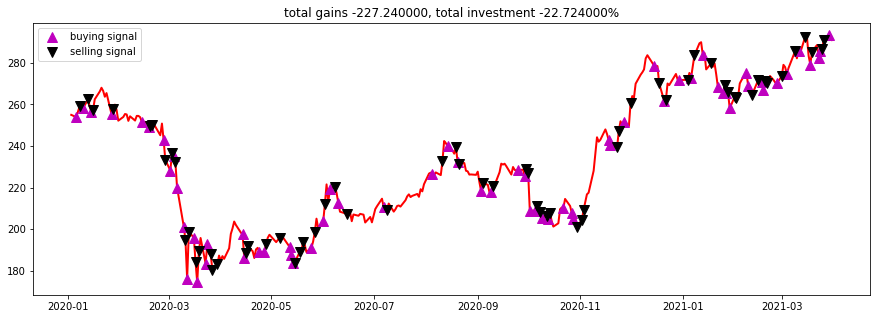

In [275]:
# Plot the results

plot_signals(values = S_actual)

##### Predicted Values

In [276]:
# Define the values for the S Stock

close = S_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 28.669153.3, cost: 0.185903, total money: 1028.669153
epoch: 20, total rewards: -10.296840.3, cost: 0.070745, total money: 989.703160
epoch: 30, total rewards: 43.934362.3, cost: 0.042277, total money: 1043.934362
epoch: 40, total rewards: -27.182172.3, cost: 0.024585, total money: 972.817828
epoch: 50, total rewards: -84.610793.3, cost: 0.021893, total money: 915.389207
epoch: 60, total rewards: -103.532079.3, cost: 0.022331, total money: 896.467921
epoch: 70, total rewards: -13.396790.3, cost: 0.014588, total money: 986.603210
epoch: 80, total rewards: -6.298519.3, cost: 0.008973, total money: 993.701481
epoch: 90, total rewards: 28.301481.3, cost: 0.007724, total money: 1028.301481
epoch: 100, total rewards: 92.321230.3, cost: 0.022584, total money: 1092.321230


In [277]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 253.900000, total balance 746.100000
day 2, sell 1 unit at price 259.150000, investment 2.067743 %, total balance 1005.250000,
day 3: buy 1 unit at price 257.990000, total balance 747.260000
day 4, sell 1 unit at price 258.190000, investment 0.077522 %, total balance 1005.450000,
day 7: buy 1 unit at price 256.310000, total balance 749.140000
day 8: buy 1 unit at price 257.510000, total balance 491.630000
day 9, sell 1 unit at price 262.500000, investment 2.415044 %, total balance 754.130000,
day 10, sell 1 unit at price 266.280000, investment 3.405693 %, total balance 1020.410000,
day 12: buy 1 unit at price 266.540000, total balance 753.870000
day 13, sell 1 unit at price 263.730000, investment -1.054251 %, total balance 1017.600000,
day 14: buy 1 unit at price 265.490000, total balance 752.110000
day 15: buy 1 unit at price 255.320000, total balance 496.790000
day 16: buy 1 unit at price 257.700000, total balance 239.090000
day 17, sell 1 unit at price 259

day 302: buy 1 unit at price 283.725418, total balance 437.263400
day 303, sell 1 unit at price 285.452651, investment 0.579007 %, total balance 722.716051,
day 304, sell 1 unit at price 286.302524, investment 0.908310 %, total balance 1009.018575,
day 307: buy 1 unit at price 285.707136, total balance 723.311439
day 308, sell 1 unit at price 288.218261, investment 0.878916 %, total balance 1011.529700,


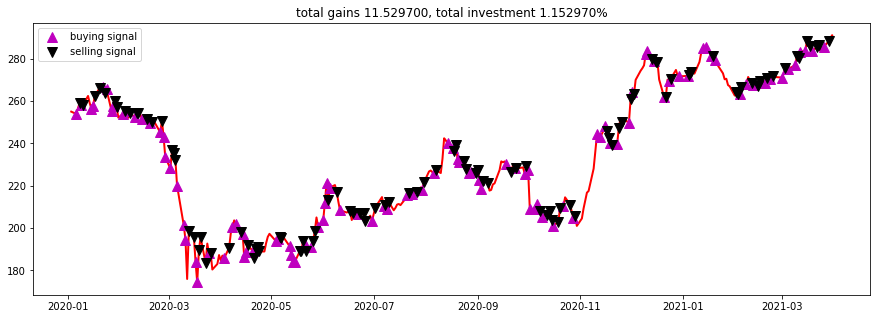

In [278]:
# Plot the results

plot_signals(values = S_predictions)

#### KCHOL Stock

##### Actual Values

In [279]:
# Define the values for the S Stock

close = KCHOL_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -0.570000.3, cost: 0.006291, total money: 999.430000
epoch: 20, total rewards: -0.390000.3, cost: 0.006064, total money: 999.610000
epoch: 30, total rewards: 0.350000.3, cost: 0.002651, total money: 1000.350000
epoch: 40, total rewards: 0.090000.3, cost: 0.002619, total money: 1000.090000
epoch: 50, total rewards: 0.090000.3, cost: 0.002637, total money: 1000.090000
epoch: 60, total rewards: -0.030000.3, cost: 0.005702, total money: 999.970000
epoch: 70, total rewards: -0.030000.3, cost: 0.005614, total money: 999.970000
epoch: 80, total rewards: -0.030000.3, cost: 0.005135, total money: 999.970000
epoch: 90, total rewards: 0.630000.3, cost: 0.002785, total money: 1000.630000
epoch: 100, total rewards: -0.370000.3, cost: 0.005365, total money: 999.630000


In [280]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 159: buy 1 unit at price 15.800000, total balance 984.200000
day 160, sell 1 unit at price 15.700000, investment -0.632911 %, total balance 999.900000,
day 172: buy 1 unit at price 14.880000, total balance 985.020000
day 173, sell 1 unit at price 14.850000, investment -0.201613 %, total balance 999.870000,


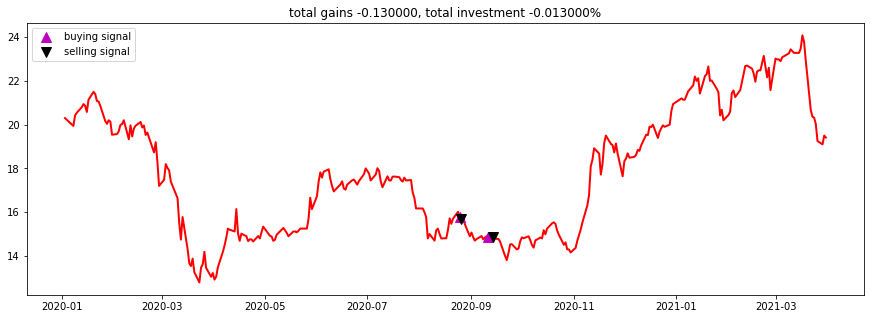

In [281]:
# Plot the results

plot_signals(values = KCHOL_actual)

##### Predicted Values

In [282]:
# Define the values for the S Stock

close = KCHOL_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 15.548234.3, cost: 0.005311, total money: 906.299992
epoch: 20, total rewards: 44.898828.3, cost: 0.017260, total money: 800.068171
epoch: 30, total rewards: -1.534656.3, cost: 0.007305, total money: 866.009688
epoch: 40, total rewards: 19.695344.3, cost: 0.005297, total money: 887.239688
epoch: 50, total rewards: 16.298547.3, cost: 0.005069, total money: 883.842891
epoch: 60, total rewards: 39.202184.3, cost: 0.007167, total money: 861.247776
epoch: 70, total rewards: 31.772184.3, cost: 0.007661, total money: 853.817776
epoch: 80, total rewards: 44.508178.3, cost: 0.005910, total money: 889.582049
epoch: 90, total rewards: 26.974044.3, cost: 0.007672, total money: 849.019637
epoch: 100, total rewards: 50.085261.3, cost: 0.016963, total money: 784.647989


In [283]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 20.080000, total balance 979.920000
day 2: buy 1 unit at price 19.940000, total balance 959.980000
day 6, sell 1 unit at price 20.940000, investment 4.282869 %, total balance 980.920000,
day 7, sell 1 unit at price 20.860000, investment 4.613842 %, total balance 1001.780000,
day 8: buy 1 unit at price 20.580000, total balance 981.200000
day 9, sell 1 unit at price 21.140000, investment 2.721088 %, total balance 1002.340000,
day 13: buy 1 unit at price 21.060000, total balance 981.280000
day 14: buy 1 unit at price 20.860000, total balance 960.420000
day 15: buy 1 unit at price 20.160000, total balance 940.260000
day 16, sell 1 unit at price 20.040000, investment -4.843305 %, total balance 960.300000,
day 18: buy 1 unit at price 20.140000, total balance 940.160000
day 19: buy 1 unit at price 19.540000, total balance 920.620000
day 20, sell 1 unit at price 19.570000, investment -6.184084 %, total balance 940.190000,
day 22: buy 1 unit at price 19.990000, total 

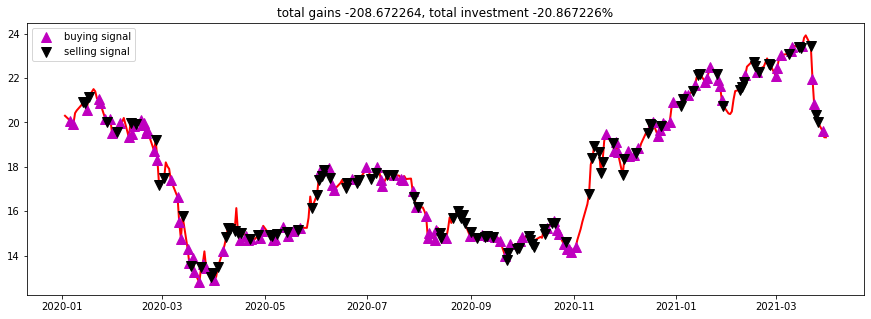

In [284]:
# Plot the results

plot_signals(values = KCHOL_predictions)

#### M Stock

##### Actual Values

In [285]:
# Define the values for the S Stock

close = M_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 6.510000.3, cost: 0.003652, total money: 899.280000
epoch: 20, total rewards: 5.560000.3, cost: 0.002487, total money: 921.380000
epoch: 30, total rewards: 4.400000.3, cost: 0.002741, total money: 916.460000
epoch: 40, total rewards: 3.740000.3, cost: 0.002489, total money: 915.720000
epoch: 50, total rewards: 2.830000.3, cost: 0.001934, total money: 929.840000
epoch: 60, total rewards: 4.650000.3, cost: 0.001638, total money: 935.380000
epoch: 70, total rewards: 1.980000.3, cost: 0.001739, total money: 932.710000
epoch: 80, total rewards: 2.100000.3, cost: 0.001199, total money: 944.570000
epoch: 90, total rewards: 0.700000.3, cost: 0.000963, total money: 950.840000
epoch: 100, total rewards: 2.760000.3, cost: 0.001636, total money: 933.490000


In [286]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 8: buy 1 unit at price 4.890000, total balance 995.110000
day 9: buy 1 unit at price 4.720000, total balance 990.390000
day 11: buy 1 unit at price 4.610000, total balance 985.780000
day 12: buy 1 unit at price 4.690000, total balance 981.090000
day 13, sell 1 unit at price 4.680000, investment -4.294479 %, total balance 985.770000,
day 14: buy 1 unit at price 4.640000, total balance 981.130000
day 15, sell 1 unit at price 4.640000, investment -1.694915 %, total balance 985.770000,
day 16: buy 1 unit at price 4.610000, total balance 981.160000
day 18, sell 1 unit at price 4.720000, investment 2.386117 %, total balance 985.880000,
day 19: buy 1 unit at price 4.720000, total balance 981.160000
day 22: buy 1 unit at price 4.690000, total balance 976.470000
day 24, sell 1 unit at price 4.670000, investment -0.426439 %, total balance 981.140000,
day 25: buy 1 unit at price 4.670000, total balance 976.470000
day 26, sell 1 unit at price 4.720000, investment 1.724138 %, total balance 981.

day 190: buy 1 unit at price 3.870000, total balance 950.340000
day 192: buy 1 unit at price 4.090000, total balance 946.250000
day 193: buy 1 unit at price 4.090000, total balance 942.160000
day 195: buy 1 unit at price 4.010000, total balance 938.150000
day 196: buy 1 unit at price 3.830000, total balance 934.320000
day 197, sell 1 unit at price 3.850000, investment 15.269461 %, total balance 938.170000,
day 198, sell 1 unit at price 3.850000, investment 14.925373 %, total balance 942.020000,
day 199, sell 1 unit at price 3.870000, investment 15.522388 %, total balance 945.890000,
day 200, sell 1 unit at price 3.840000, investment 15.315315 %, total balance 949.730000,
day 201: buy 1 unit at price 3.720000, total balance 946.010000
day 203: buy 1 unit at price 3.740000, total balance 942.270000
day 204, sell 1 unit at price 3.790000, investment 9.221902 %, total balance 946.060000,
day 205, sell 1 unit at price 3.680000, investment 6.051873 %, total balance 949.740000,
day 206: buy 1

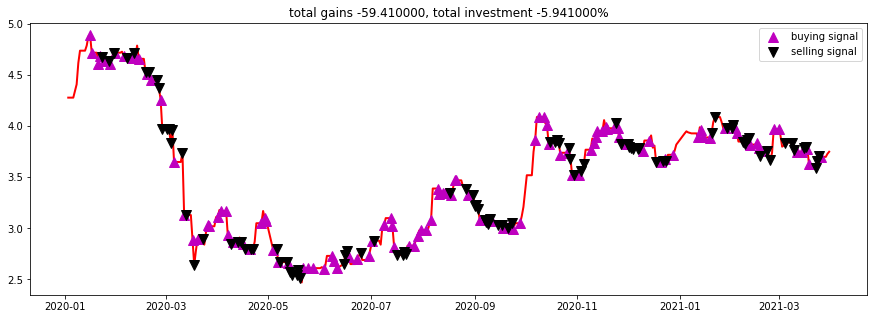

In [287]:
# Plot the results

plot_signals(values = M_actual)

##### Predicted Values

In [288]:
# Define the values for the S Stock

close = M_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 16.811834.3, cost: 0.014455, total money: 808.759733
epoch: 20, total rewards: 15.437867.3, cost: 0.007143, total money: 875.674141
epoch: 30, total rewards: 12.022154.3, cost: 0.005427, total money: 896.044387
epoch: 40, total rewards: 15.112185.3, cost: 0.005438, total money: 890.962301
epoch: 50, total rewards: 12.993525.3, cost: 0.003670, total money: 908.111135
epoch: 60, total rewards: 9.676410.3, cost: 0.003094, total money: 920.673355
epoch: 70, total rewards: 9.493840.3, cost: 0.002494, total money: 931.844255
epoch: 80, total rewards: 3.972161.3, cost: 0.000937, total money: 965.033570
epoch: 90, total rewards: 1.811488.3, cost: 0.000724, total money: 970.968264
epoch: 100, total rewards: 0.094056.3, cost: 0.000042, total money: 1000.094056


In [289]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 4.410000, total balance 995.590000
day 3: buy 1 unit at price 4.620000, total balance 990.970000
day 4: buy 1 unit at price 4.740000, total balance 986.230000
day 5: buy 1 unit at price 4.740000, total balance 981.490000
day 7: buy 1 unit at price 4.880000, total balance 976.610000
day 8: buy 1 unit at price 4.890000, total balance 971.720000
day 11, sell 1 unit at price 4.610000, investment 4.535147 %, total balance 976.330000,
day 12: buy 1 unit at price 4.690000, total balance 971.640000
day 13, sell 1 unit at price 4.680000, investment 1.298701 %, total balance 976.320000,
day 14: buy 1 unit at price 4.640000, total balance 971.680000
day 15, sell 1 unit at price 4.640000, investment -2.109705 %, total balance 976.320000,
day 16: buy 1 unit at price 4.610000, total balance 971.710000
day 19: buy 1 unit at price 4.720000, total balance 966.990000
day 21: buy 1 unit at price 4.730000, total balance 962.260000
day 24, sell 1 unit at price 4.670000, investmen

day 212: buy 1 unit at price 3.770000, total balance 957.370000
day 213: buy 1 unit at price 3.880000, total balance 953.490000
day 214: buy 1 unit at price 3.840000, total balance 949.650000
day 215: buy 1 unit at price 3.890000, total balance 945.760000
day 216: buy 1 unit at price 3.950000, total balance 941.810000
day 217: buy 1 unit at price 3.950000, total balance 937.860000
day 219: buy 1 unit at price 3.990000, total balance 933.870000
day 222: buy 1 unit at price 3.980000, total balance 929.890000
day 224, sell 1 unit at price 3.980000, investment -2.689487 %, total balance 933.870000,
day 225, sell 1 unit at price 3.890000, investment -4.889976 %, total balance 937.760000,
day 226, sell 1 unit at price 3.830000, investment -6.356968 %, total balance 941.590000,
day 227: buy 1 unit at price 3.830000, total balance 937.760000
day 228, sell 1 unit at price 3.830000, investment -4.488778 %, total balance 941.590000,
day 229, sell 1 unit at price 3.800000, investment -1.808786 %, 

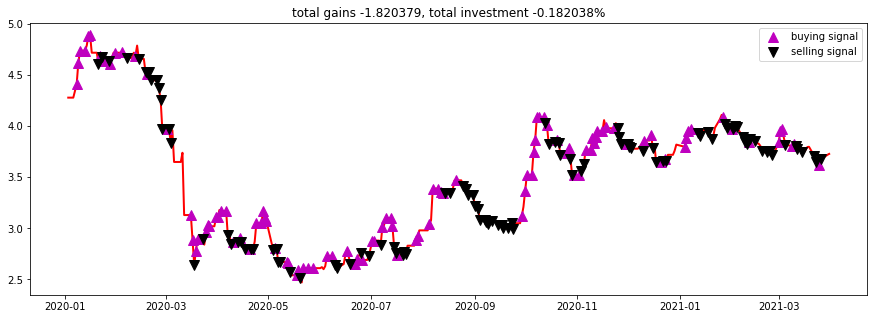

In [290]:
# Plot the results

plot_signals(values = M_predictions)

#### BEEF Stock

##### Actual Values

In [291]:
# Define the values for the S Stock

close = BEEF_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -24.600000.3, cost: 0.028873, total money: 720.900000
epoch: 20, total rewards: -32.290000.3, cost: 0.020053, total money: 783.620000
epoch: 30, total rewards: -37.480000.3, cost: 0.019051, total money: 788.280000
epoch: 40, total rewards: -42.400000.3, cost: 0.021184, total money: 773.510000
epoch: 50, total rewards: -36.660000.3, cost: 0.015436, total money: 809.330000
epoch: 60, total rewards: -33.040000.3, cost: 0.016185, total money: 802.590000
epoch: 70, total rewards: -29.550000.3, cost: 0.015488, total money: 806.080000
epoch: 80, total rewards: -21.750000.3, cost: 0.009341, total money: 853.830000
epoch: 90, total rewards: -21.100000.3, cost: 0.006612, total money: 892.860000
epoch: 100, total rewards: -31.120000.3, cost: 0.008343, total money: 873.600000


In [292]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 18: buy 1 unit at price 11.420000, total balance 988.580000
day 21: buy 1 unit at price 12.040000, total balance 976.540000
day 22: buy 1 unit at price 12.100000, total balance 964.440000
day 23: buy 1 unit at price 11.900000, total balance 952.540000
day 28: buy 1 unit at price 11.840000, total balance 940.700000
day 29: buy 1 unit at price 11.790000, total balance 928.910000
day 30, sell 1 unit at price 12.250000, investment 7.267951 %, total balance 941.160000,
day 32, sell 1 unit at price 12.550000, investment 4.235880 %, total balance 953.710000,
day 33: buy 1 unit at price 12.410000, total balance 941.300000
day 35, sell 1 unit at price 12.760000, investment 5.454545 %, total balance 954.060000,
day 36: buy 1 unit at price 11.800000, total balance 942.260000
day 40: buy 1 unit at price 11.970000, total balance 930.290000
day 41, sell 1 unit at price 12.200000, investment 2.521008 %, total balance 942.490000,
day 42: buy 1 unit at price 11.300000, total balance 931.190000
day 

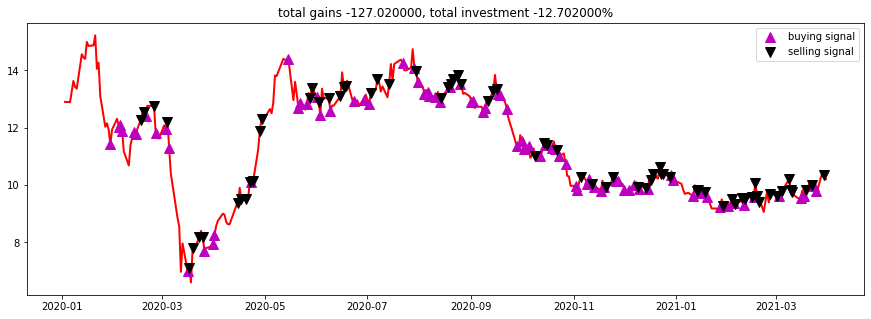

In [293]:
# Plot the results

plot_signals(values = BEEF_actual)

##### Predicted Values

In [294]:
# Define the values for the S Stock

close = BEEF_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 3.396464.3, cost: 0.001098, total money: 944.030737
epoch: 20, total rewards: 3.120418.3, cost: 0.000593, total money: 953.880006
epoch: 30, total rewards: -2.831313.3, cost: 0.000718, total money: 947.928275
epoch: 40, total rewards: -0.324228.3, cost: 0.000450, total money: 960.089411
epoch: 50, total rewards: -2.035281.3, cost: 0.000652, total money: 948.724307
epoch: 60, total rewards: 0.059843.3, cost: 0.000758, total money: 940.694116
epoch: 70, total rewards: -8.362230.3, cost: 0.000781, total money: 942.397357
epoch: 80, total rewards: -0.942230.3, cost: 0.000564, total money: 949.817357
epoch: 90, total rewards: 1.697770.3, cost: 0.000493, total money: 952.457357
epoch: 100, total rewards: 1.045379.3, cost: 0.000524, total money: 951.804966


In [295]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 13.630000, total balance 986.370000
day 4, sell 1 unit at price 13.360000, investment -1.980924 %, total balance 999.730000,
day 6: buy 1 unit at price 14.450000, total balance 985.280000
day 7, sell 1 unit at price 14.400000, investment -0.346021 %, total balance 999.680000,
day 9: buy 1 unit at price 14.850000, total balance 984.830000
day 10, sell 1 unit at price 14.870000, investment 0.134680 %, total balance 999.700000,
day 17: buy 1 unit at price 11.930000, total balance 987.770000
day 18, sell 1 unit at price 11.420000, investment -4.274937 %, total balance 999.190000,
day 26: buy 1 unit at price 11.390000, total balance 987.800000
day 28, sell 1 unit at price 11.840000, investment 3.950834 %, total balance 999.640000,
day 30: buy 1 unit at price 12.250000, total balance 987.390000
day 31: buy 1 unit at price 12.500000, total balance 974.890000
day 32: buy 1 unit at price 12.550000, total balance 962.340000
day 34: buy 1 unit at price 12.760000, total 

day 219: buy 1 unit at price 10.150000, total balance 991.590000
day 221, sell 1 unit at price 9.940000, investment -2.068966 %, total balance 1001.530000,
day 223: buy 1 unit at price 10.270000, total balance 991.260000
day 225, sell 1 unit at price 10.140000, investment -1.265823 %, total balance 1001.400000,
day 227: buy 1 unit at price 10.030000, total balance 991.370000
day 228, sell 1 unit at price 9.830000, investment -1.994018 %, total balance 1001.200000,
day 230: buy 1 unit at price 9.810000, total balance 991.390000
day 232: buy 1 unit at price 10.010000, total balance 981.380000
day 234, sell 1 unit at price 9.920000, investment 1.121305 %, total balance 991.300000,
day 235, sell 1 unit at price 9.850000, investment -1.598402 %, total balance 1001.150000,
day 237: buy 1 unit at price 9.880000, total balance 991.270000
day 238, sell 1 unit at price 9.870000, investment -0.101215 %, total balance 1001.140000,
day 239: buy 1 unit at price 10.290000, total balance 990.850000
da

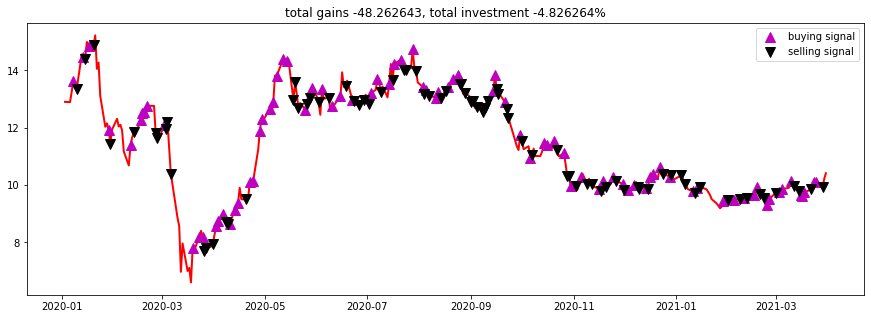

In [296]:
# Plot the results

plot_signals(values = BEEF_predictions)

#### P Stock

##### Actual Values

In [297]:
# Define the values for the S Stock

close = P_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 773.550000.3, cost: 0.623782, total money: 7.100000
epoch: 20, total rewards: 940.000000.3, cost: 0.443348, total money: 224.350000
epoch: 30, total rewards: 760.800000.3, cost: 0.369923, total money: 289.450000
epoch: 40, total rewards: 487.450000.3, cost: 0.312900, total money: 393.650000
epoch: 50, total rewards: 229.400000.3, cost: 0.222704, total money: 814.100000
epoch: 60, total rewards: 195.300000.3, cost: 0.167669, total money: 787.400000
epoch: 70, total rewards: 160.800000.3, cost: 0.163290, total money: 836.700000
epoch: 80, total rewards: 147.600000.3, cost: 0.113905, total money: 905.300000
epoch: 90, total rewards: 122.800000.3, cost: 0.125525, total money: 960.000000
epoch: 100, total rewards: 84.250000.3, cost: 0.065413, total money: 1000.650000


In [298]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 48.100000, total balance 951.900000
day 6, sell 1 unit at price 45.850000, investment -4.677755 %, total balance 997.750000,
day 9: buy 1 unit at price 48.350000, total balance 949.400000
day 12, sell 1 unit at price 48.450000, investment 0.206825 %, total balance 997.850000,
day 14: buy 1 unit at price 44.800000, total balance 953.050000
day 15, sell 1 unit at price 45.300000, investment 1.116071 %, total balance 998.350000,
day 16: buy 1 unit at price 46.300000, total balance 952.050000
day 17: buy 1 unit at price 45.000000, total balance 907.050000
day 18, sell 1 unit at price 45.800000, investment -1.079914 %, total balance 952.850000,
day 19, sell 1 unit at price 45.200000, investment 0.444444 %, total balance 998.050000,
day 20: buy 1 unit at price 47.750000, total balance 950.300000
day 22, sell 1 unit at price 46.350000, investment -2.931937 %, total balance 996.650000,
day 31: buy 1 unit at price 42.250000, total balance 954.400000
day 34: buy 1 unit

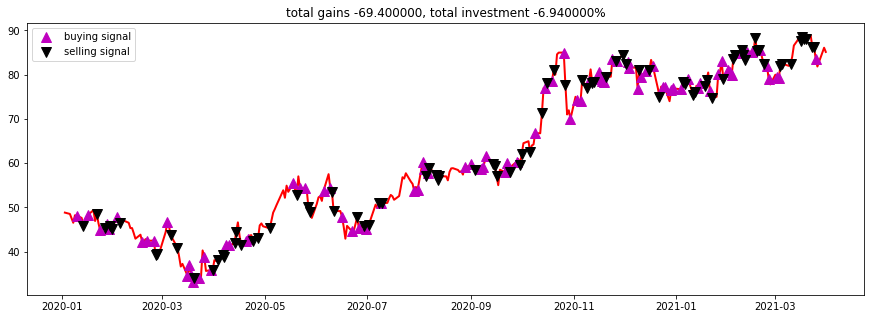

In [299]:
# Plot the results

plot_signals(values = P_actual)

##### Predicted Values

In [300]:
# Define the values for the S Stock

close = P_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 836.168945.3, cost: 0.335329, total money: 54.752435
epoch: 20, total rewards: 810.511971.3, cost: 0.311743, total money: 32.345286
epoch: 30, total rewards: 630.805931.3, cost: 0.234954, total money: 255.407326
epoch: 40, total rewards: 364.216440.3, cost: 0.210645, total money: 372.544565
epoch: 50, total rewards: 177.218645.3, cost: 0.064309, total money: 506.843159
epoch: 60, total rewards: 103.508369.3, cost: 0.019766, total money: 847.960522
epoch: 70, total rewards: 104.562838.3, cost: 0.026398, total money: 675.671656
epoch: 80, total rewards: 103.859389.3, cost: 0.008776, total money: 1021.817782
epoch: 90, total rewards: 64.506075.3, cost: 0.003935, total money: 1064.506075
epoch: 100, total rewards: 69.967125.3, cost: 0.008363, total money: 987.925517


In [301]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 10: buy 1 unit at price 49.350000, total balance 950.650000
day 11: buy 1 unit at price 46.900000, total balance 903.750000
day 12, sell 1 unit at price 48.450000, investment -1.823708 %, total balance 952.200000,
day 14, sell 1 unit at price 44.800000, investment -4.477612 %, total balance 997.000000,
day 15: buy 1 unit at price 45.300000, total balance 951.700000
day 16, sell 1 unit at price 46.300000, investment 2.207506 %, total balance 998.000000,
day 21: buy 1 unit at price 46.900000, total balance 951.100000
day 22, sell 1 unit at price 46.350000, investment -1.172708 %, total balance 997.450000,
day 30: buy 1 unit at price 43.800000, total balance 953.650000
day 32, sell 1 unit at price 42.100000, investment -3.881279 %, total balance 995.750000,
day 36: buy 1 unit at price 39.250000, total balance 956.500000
day 37, sell 1 unit at price 39.400000, investment 0.382166 %, total balance 995.900000,
day 40: buy 1 unit at price 44.400000, total balance 951.500000
day 41: buy 1 

day 209: buy 1 unit at price 74.250000, total balance 653.500000
day 211: buy 1 unit at price 78.800000, total balance 574.700000
day 212, sell 1 unit at price 76.950000, investment -3.812500 %, total balance 651.650000,
day 213, sell 1 unit at price 78.500000, investment -7.647059 %, total balance 730.150000,
day 214: buy 1 unit at price 81.200000, total balance 648.950000
day 215, sell 1 unit at price 78.100000, investment 0.579524 %, total balance 727.050000,
day 216, sell 1 unit at price 78.400000, investment 8.964559 %, total balance 805.450000,
day 218, sell 1 unit at price 79.000000, investment 6.397306 %, total balance 884.450000,
day 219, sell 1 unit at price 78.650000, investment -0.190355 %, total balance 963.100000,
day 221, sell 1 unit at price 79.550000, investment -2.032020 %, total balance 1042.650000,
day 224: buy 1 unit at price 83.000000, total balance 959.650000
day 225: buy 1 unit at price 83.200000, total balance 876.450000
day 226: buy 1 unit at price 83.200000, 

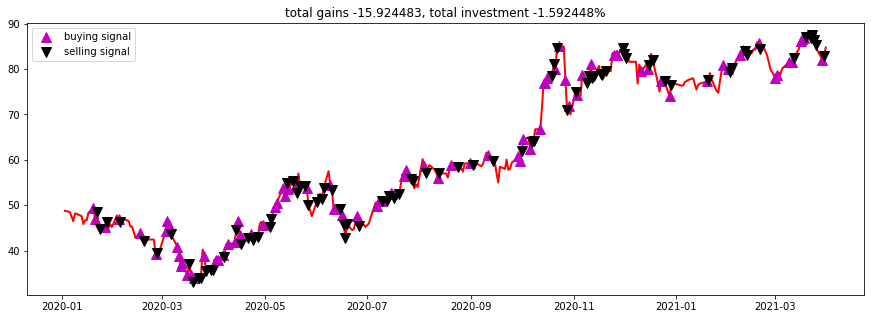

In [302]:
# Plot the results

plot_signals(values = P_predictions)

#### C Stock

##### Actual Values

In [312]:
# Different variables for this stock (May vary depending on the stock)
initial_money = 10000

# Define the values for the S Stock

close = C_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -97.000000.3, cost: 0.137750, total money: 9903.000000
epoch: 20, total rewards: -167.000000.3, cost: 0.273580, total money: 9833.000000
epoch: 30, total rewards: -412.000000.3, cost: 0.041065, total money: 9588.000000
epoch: 40, total rewards: -352.000000.3, cost: 0.030587, total money: 9648.000000
epoch: 50, total rewards: -2.000000.3, cost: 0.024167, total money: 9998.000000
epoch: 60, total rewards: 800.000000.3, cost: 0.049294, total money: 10800.000000
epoch: 70, total rewards: -595.000000.3, cost: 0.012961, total money: 9405.000000
epoch: 80, total rewards: 233.000000.3, cost: 0.029229, total money: 10233.000000
epoch: 90, total rewards: 663.000000.3, cost: 0.036446, total money: 10663.000000
epoch: 100, total rewards: -709.000000.3, cost: 0.033796, total money: 9291.000000


In [313]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 14: buy 1 unit at price 6500.000000, total balance 3500.000000
day 15, sell 1 unit at price 6450.000000, investment -0.769231 %, total balance 9950.000000,
day 21: buy 1 unit at price 6500.000000, total balance 3450.000000
day 22, sell 1 unit at price 6530.000000, investment 0.461538 %, total balance 9980.000000,
day 28: buy 1 unit at price 6200.000000, total balance 3780.000000
day 29, sell 1 unit at price 6200.000000, investment 0.000000 %, total balance 9980.000000,
day 31: buy 1 unit at price 6110.000000, total balance 3870.000000
day 35, sell 1 unit at price 5460.000000, investment -10.638298 %, total balance 9330.000000,
day 37: buy 1 unit at price 5200.000000, total balance 4130.000000
day 38, sell 1 unit at price 5300.000000, investment 1.923077 %, total balance 9430.000000,
day 42: buy 1 unit at price 5110.000000, total balance 4320.000000
day 44, sell 1 unit at price 4500.000000, investment -11.937378 %, total balance 8820.000000,
day 47: buy 1 unit at price 4000.000000, 

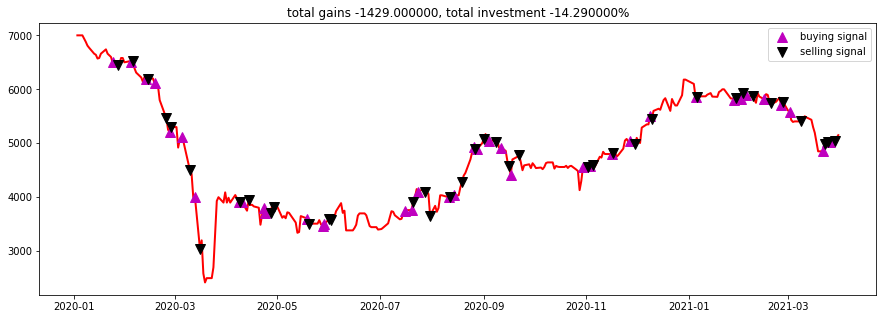

In [314]:
# Plot the results

plot_signals(values = C_actual)

##### Predicted Values

In [315]:
# Define the values for the S Stock

close = C_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -667.067437.3, cost: 0.117845, total money: 9332.932563
epoch: 20, total rewards: -478.858848.3, cost: 0.052799, total money: 9521.141152
epoch: 30, total rewards: -1061.410431.3, cost: 0.034026, total money: 8938.589569
epoch: 40, total rewards: -847.782437.3, cost: 0.042662, total money: 9152.217563
epoch: 50, total rewards: -300.691613.3, cost: 0.036344, total money: 9699.308387
epoch: 60, total rewards: -478.289392.3, cost: 0.023733, total money: 9521.710608
epoch: 70, total rewards: -560.634729.3, cost: 0.036181, total money: 9439.365271
epoch: 80, total rewards: -833.226772.3, cost: 0.020902, total money: 9166.773228
epoch: 90, total rewards: -849.226772.3, cost: 0.018390, total money: 9150.773228
epoch: 100, total rewards: -450.813239.3, cost: 0.022501, total money: 9549.186761


In [316]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 19: buy 1 unit at price 6500.000000, total balance 3500.000000
day 21, sell 1 unit at price 6500.000000, investment 0.000000 %, total balance 10000.000000,
day 34: buy 1 unit at price 5800.000000, total balance 4200.000000
day 36, sell 1 unit at price 5250.000000, investment -9.482759 %, total balance 9450.000000,
day 42: buy 1 unit at price 5110.000000, total balance 4340.000000
day 43, sell 1 unit at price 5050.000000, investment -1.174168 %, total balance 9390.000000,
day 48: buy 1 unit at price 3040.000000, total balance 6350.000000
day 49, sell 1 unit at price 3200.000000, investment 5.263158 %, total balance 9550.000000,
day 56: buy 1 unit at price 3930.000000, total balance 5620.000000
day 57, sell 1 unit at price 4000.000000, investment 1.781170 %, total balance 9620.000000,
day 58: buy 1 unit at price 3900.000000, total balance 5720.000000
day 59, sell 1 unit at price 4090.000000, investment 4.871795 %, total balance 9810.000000,
day 67: buy 1 unit at price 3905.000000, to

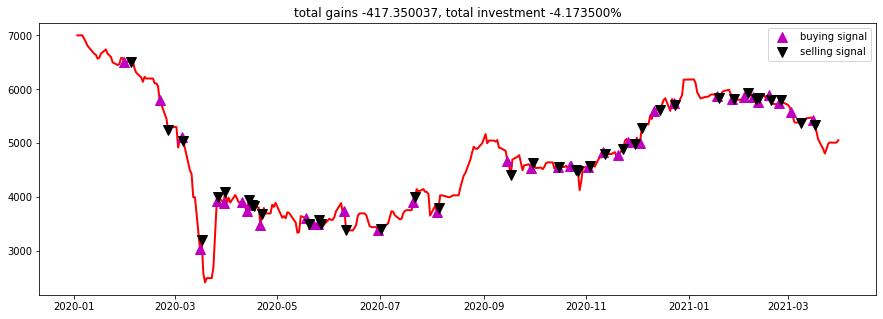

In [317]:
# Plot the results

plot_signals(values = C_predictions)

#### IP Stock

##### Actual Values

In [360]:
# Different variables for this stock (May vary depending on the stock)
initial_money = 100000

# Define the values for the S Stock

close = IP_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 5085.000000.3, cost: nan, total money: 77485.000000
epoch: 20, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 30, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 40, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 50, total rewards: 0.000000.3, cost: nan, total money: 82568.000000
epoch: 60, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 70, total rewards: 0.000000.3, cost: nan, total money: 86877.000000
epoch: 80, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 90, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 100, total rewards: 0.000000.3, cost: nan, total money: 100000.000000


In [361]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 39: buy 1 unit at price 12780.000000, total balance 87220.000000
day 165, sell 1 unit at price 15527.000000, investment 21.494523 %, total balance 102747.000000,


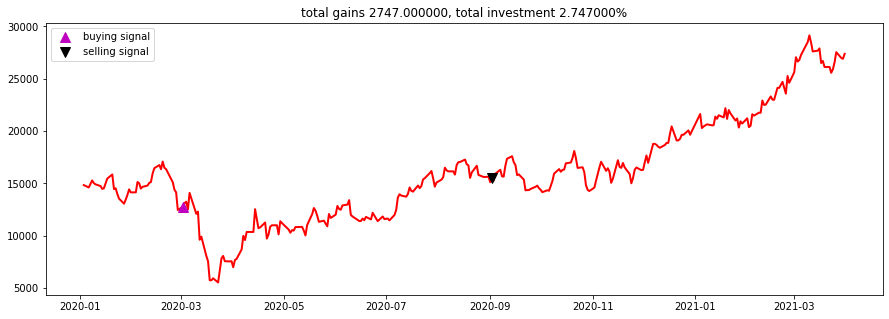

In [362]:
# Plot the results

plot_signals(values = IP_actual)

##### Predicted Values

In [363]:
# Define the values for the S Stock

close = IP_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 6407.000000.3, cost: nan, total money: 90807.000000
epoch: 20, total rewards: 2056.000000.3, cost: nan, total money: 75399.000000
epoch: 30, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 40, total rewards: 5230.000000.3, cost: nan, total money: 105230.000000
epoch: 50, total rewards: 0.000000.3, cost: nan, total money: 67814.000000
epoch: 60, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 70, total rewards: 0.000000.3, cost: nan, total money: 34331.627930
epoch: 80, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 90, total rewards: 7687.000000.3, cost: nan, total money: 97317.000000
epoch: 100, total rewards: 14009.760742.3, cost: nan, total money: 93184.336914


In [364]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 295: buy 1 unit at price 26909.585938, total balance 73090.414062


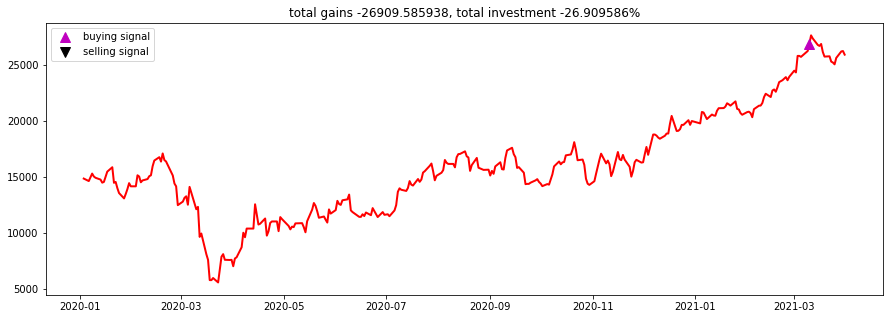

In [365]:
# Plot the results

plot_signals(values = IP_predictions)

#### DS Stock

##### Actual Values

In [346]:
# Define the values for the S Stock

close = DS_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 8635.000000.3, cost: 0.835474, total money: 108635.000000
epoch: 20, total rewards: 7660.000000.3, cost: 0.536678, total money: 72760.000000
epoch: 30, total rewards: 5300.000000.3, cost: 0.112269, total money: 105300.000000
epoch: 40, total rewards: 5355.000000.3, cost: 0.056112, total money: 105355.000000
epoch: 50, total rewards: 7915.000000.3, cost: 0.031341, total money: 107915.000000
epoch: 60, total rewards: 7410.000000.3, cost: 0.191953, total money: 107410.000000
epoch: 70, total rewards: 6175.000000.3, cost: 0.072019, total money: 106175.000000
epoch: 80, total rewards: 6460.000000.3, cost: 0.066530, total money: 106460.000000
epoch: 90, total rewards: 6310.000000.3, cost: 0.012989, total money: 106310.000000
epoch: 100, total rewards: 10635.000000.3, cost: 0.086302, total money: 110635.000000


In [347]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 17: buy 1 unit at price 5020.000000, total balance 94980.000000
day 18, sell 1 unit at price 4935.000000, investment -1.693227 %, total balance 99915.000000,
day 28: buy 1 unit at price 5420.000000, total balance 94495.000000
day 29, sell 1 unit at price 5370.000000, investment -0.922509 %, total balance 99865.000000,
day 33: buy 1 unit at price 4965.000000, total balance 94900.000000
day 36, sell 1 unit at price 4780.000000, investment -3.726083 %, total balance 99680.000000,
day 54: buy 1 unit at price 3260.000000, total balance 96420.000000
day 55, sell 1 unit at price 3485.000000, investment 6.901840 %, total balance 99905.000000,
day 60: buy 1 unit at price 3585.000000, total balance 96320.000000
day 61, sell 1 unit at price 3590.000000, investment 0.139470 %, total balance 99910.000000,
day 68: buy 1 unit at price 3900.000000, total balance 96010.000000
day 70: buy 1 unit at price 3965.000000, total balance 92045.000000
day 72, sell 1 unit at price 4080.000000, investment 4.6

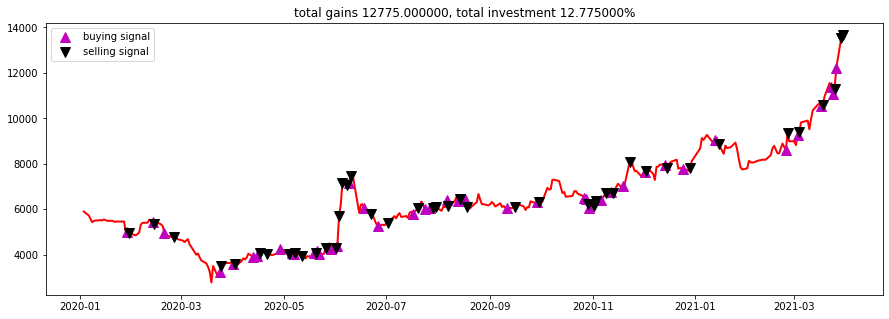

In [348]:
# Plot the results

plot_signals(values = DS_actual)

##### Predicted Values

In [349]:
# Define the values for the S Stock

close = DS_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -1913.213379.3, cost: 0.285212, total money: 65356.353516
epoch: 20, total rewards: 1083.130371.3, cost: 0.084072, total money: 79041.515625
epoch: 30, total rewards: 509.438477.3, cost: 0.040928, total money: 78467.823730
epoch: 40, total rewards: -1260.036621.3, cost: 0.018702, total money: 76698.348633
epoch: 50, total rewards: 29.525635.3, cost: 0.015807, total money: 77987.910889
epoch: 60, total rewards: -5087.539551.3, cost: 0.021874, total money: 72870.845703
epoch: 70, total rewards: -3409.065186.3, cost: 0.007998, total money: 74549.320068
epoch: 80, total rewards: 1971.213623.3, cost: 0.031638, total money: 79929.598877
epoch: 90, total rewards: -5450.212646.3, cost: 0.006627, total money: 83334.038330
epoch: 100, total rewards: -2761.068604.3, cost: 0.037795, total money: 53752.048096


In [350]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 5490.000000, total balance 94510.000000
day 4: buy 1 unit at price 5500.000000, total balance 89010.000000
day 5: buy 1 unit at price 5520.000000, total balance 83490.000000
day 6, sell 1 unit at price 5510.000000, investment 0.364299 %, total balance 89000.000000,
day 7: buy 1 unit at price 5550.000000, total balance 83450.000000
day 8: buy 1 unit at price 5520.000000, total balance 77930.000000
day 9: buy 1 unit at price 5490.000000, total balance 72440.000000
day 10: buy 1 unit at price 5490.000000, total balance 66950.000000
day 12: buy 1 unit at price 5450.000000, total balance 61500.000000
day 13: buy 1 unit at price 5460.000000, total balance 56040.000000
day 14, sell 1 unit at price 5460.000000, investment -0.727273 %, total balance 61500.000000,
day 15: buy 1 unit at price 5460.000000, total balance 56040.000000
day 17, sell 1 unit at price 5020.000000, investment -9.057971 %, total balance 61060.000000,
day 18: buy 1 unit at price 4935.000000, total

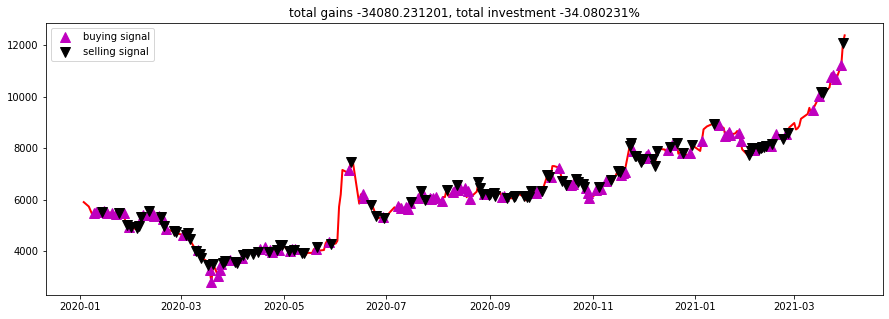

In [351]:
# Plot the results

plot_signals(values = DS_predictions)

## Approach

1. Get the historical data of the stock prices
2. Preprocess the data. Apply MinMax Scaler, re arrange the data and use the 5 days prior as independant variables and the day ahead as the dependant variable and make sure to use the correct dimensions for the data, and after applying the MinMax Scaler, prevent data leakeage by just fitting the train data
3. To foreast values, we are going to to use LSTM to see the general trend. As a note, depending on the days of data and the number of days used as independant features, we may be able to forecast prices with a longer period.
4. To calculate the next day forecast, we are using arima model (This won't work for long forecasting periods as it would capture the general trend).
5. To calculate the overal performance of both, we are using the bollinger bands and each indicator would give buy-sell signals.
6. We are calculating the weighted average between the arima model and the LSTM model.
7. We are using reinforcement learnings to check the overal buy and sell recommendations based on the forecast made with the LSTM and compare the results with the actual results. For the reinforcement learning you should input a sufficient initial investment to cover one stock price